In [1]:
# import libraries we need
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc, confusion_matrix, classification_report, precision_recall_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import AUC, Precision, Recall

/Users/hepplexi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Datasets

In [2]:
# Load the dataset
df_train = pd.read_csv('UNSW_NB15_training-set.csv')
df_test = pd.read_csv('UNSW_NB15_testing-set.csv')
pd.set_option('display.max_columns', None)

## Data Pre-Processing

### Imblanced piecahrt

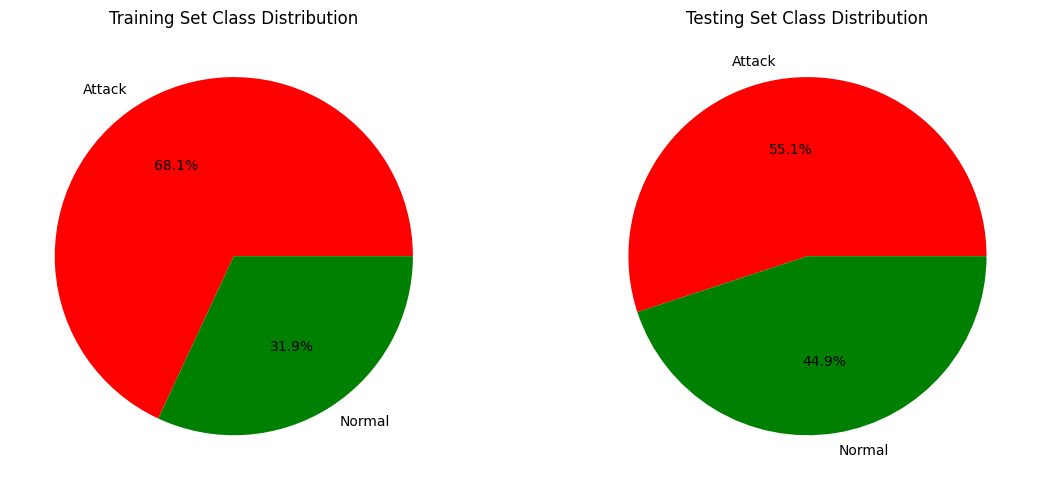

Training Set:
Total Samples: 175341
Normal Instances: 56000
Attack Instances: 119341

Testing Set:
Total Samples: 82332
Normal Instances: 37000
Attack Instances: 45332


In [3]:
# Count attacks and normal instances in training set
train_attack = len(df_train[df_train['label'] == 1])
train_normal = len(df_train[df_train['label'] == 0])

# Count attacks and normal instances in testing set
test_attack = len(df_test[df_test['label'] == 1])
test_normal = len(df_test[df_test['label'] == 0])

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Training set pie chart
train_sizes = [train_attack, train_normal]
train_labels = ['Attack', 'Normal']
ax1.pie(train_sizes, labels=train_labels, autopct='%1.1f%%', colors=['Red', 'Green'])
ax1.set_title('Training Set Class Distribution')

# Testing set pie chart
test_sizes = [test_attack, test_normal]
test_labels = ['Attack', 'Normal']
ax2.pie(test_sizes, labels=test_labels, autopct='%1.1f%%', colors=['Red', 'Green'])
ax2.set_title('Testing Set Class Distribution')

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print out the exact numbers for reference
print("Training Set:")
print(f"Total Samples: {len(df_train)}")
print(f"Normal Instances: {train_normal}")
print(f"Attack Instances: {train_attack}")

print("\nTesting Set:")
print(f"Total Samples: {len(df_test)}")
print(f"Normal Instances: {test_normal}")
print(f"Attack Instances: {test_attack}")

### NA Check

In [4]:
# NACheck
NACheck = df_train.apply(lambda x: x.isna().sum(), axis=1)
NACheck.describe()

count    175341.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
dtype: float64

In [5]:
NACheck = df_test.apply(lambda x: x.isna().sum(), axis=1)
NACheck.describe()

count    82332.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
dtype: float64

### Missing data:
There are **no missing values** in the dataset at all.
### Imbalanced data:
As we can see, the data we get is **seriously imbalanced**.

### Correlation Heatmap

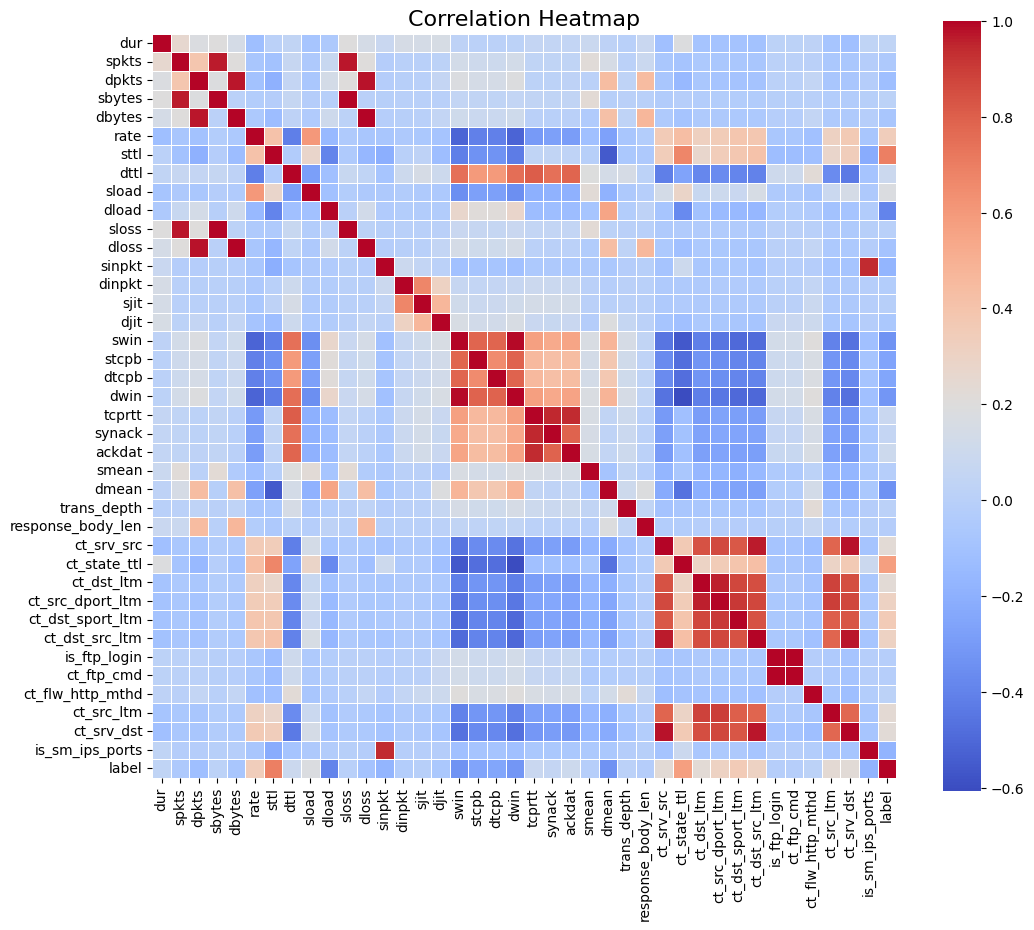

In [6]:
# Drop object/string columns
string_columns = df_train.select_dtypes(include=['object']).columns
df_train = df_train.drop(columns=string_columns)
df_train = df_train.drop('id', axis=1)
# Compute the correlation matrix
correlation_matrix = df_train.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", cbar=True, square=True, linewidths=0.5)

# Add title
plt.title("Correlation Heatmap", fontsize=16)

# Display the heatmap
plt.show()

### Feature Selection
Choose Which feature is useful for the Thread Detection using correlation and ANOVA

#### Correlation

In [7]:
# Compute Correlation with the target column 'label'
correlation = df_train.corrwith(df_train['label']).sort_values(ascending=False).to_frame()
correlation.columns = ['corr']  

# Select features with significant positive correlation (> 0.1)
PositiveCorrelation = correlation[correlation['corr'] > 0.1]

# Select features with significant negative correlation (< -0.1)
NegativeCorrelation = correlation[correlation['corr'] < -0.1]

# Combine positively and negatively correlated features
FeatureTemp = NegativeCorrelation.index.append(PositiveCorrelation.index)

# Create a subset of the DataFrame with these features
FilterSelectionColumn = df_train[FeatureTemp]  # Subset DataFrame with selected features
correlation

,corr
label,1.000000
sttl,0.692741
ct_state_ttl,0.577704
ct_dst_sport_ltm,0.357213
rate,0.337979
ct_src_dport_ltm,0.305579
ct_dst_src_ltm,0.303855
ct_src_ltm,0.238225
ct_dst_ltm,0.229887
ct_srv_src,0.229044


#### ANOVA

In [8]:
# Prepare features and target for ANOVA
features = df_train.drop('label', axis=1)  # Drop 'label' to isolate features
target = df_train['label']  # Target variable

# Use SelectKBest with ANOVA (f_classif) to score features
best_features = SelectKBest(score_func=f_classif, k='all')  # Evaluate all features
fit = best_features.fit(features, target)  # Fit the ANOVA model

# Store ANOVA scores in a DataFrame for easier interpretation
featureScores = pd.DataFrame(data=fit.scores_, index=list(features.columns), columns=['ANOVA Score'])
featureScores

,ANOVA Score
dur,229.749327
spkts,478.672832
dpkts,2501.116244
sbytes,60.522430
dbytes,1042.259653
rate,22611.817828
sttl,161780.526952
dttl,1598.495322
sload,6066.435816
dload,32170.312851


#### Feature Selection
Select the features where both ANOVA and correlation significantly contribute to the classification process.

In [9]:
# Combine Correlation and ANOVA results
# Merge correlation and ANOVA scores into a single DataFrame
combined_scores = featureScores.merge(correlation, left_index=True, right_index=True)

# Filter features where both correlation and ANOVA score thresholds are satisfied
# (ANOVA Score > threshold, correlation > 0.1 or < -0.1)
anova_threshold = 2000  # Example threshold for ANOVA scores
selected_features = combined_scores[
    (combined_scores['corr'].abs() > 0.1) & (combined_scores['ANOVA Score'] > anova_threshold)
]

# Subset the original DataFrame with the selected features
final_selected_features = selected_features.index.tolist()  # Get the names of selected features
final_df = df_train[final_selected_features + ['label']]  # Include 'label' column for classification tasks

# Display the selected features and scores
print("Selected Features Based on Correlation and ANOVA:")
print(selected_features)

# Final filtered DataFrame for model training or evaluation
print("\nFinal DataFrame with Selected Features:")
final_df

Selected Features Based on Correlation and ANOVA:
                    ANOVA Score      corr
dpkts               2501.116244 -0.118591
rate               22611.817828  0.337979
sttl              161780.526952  0.692741
sload               6066.435816  0.182870
dload              32170.312851 -0.393739
sinpkt              5612.172675 -0.176110
swin               21961.796620 -0.333633
stcpb              12194.973688 -0.255006
dtcpb              11723.168274 -0.250340
dwin               19950.909669 -0.319626
dmean              23195.039749 -0.341806
ct_srv_src          9707.760648  0.229044
ct_state_ttl       87830.779493  0.577704
ct_dst_ltm          9783.377995  0.229887
ct_src_dport_ltm   18059.210546  0.305579
ct_dst_sport_ltm   25645.955324  0.357213
ct_dst_src_ltm     17835.399757  0.303855
ct_src_ltm         10549.386809  0.238225
ct_srv_dst          9618.746066  0.228046
is_sm_ips_ports     6191.368613 -0.184679

Final DataFrame with Selected Features:


,dpkts,rate,sttl,sload,dload,sinpkt,swin,stcpb,dtcpb,dwin,dmean,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,4,74.087490,252,1.415894e+04,8495.365234,24.295600,255,621772692,2202533631,255,43,1,0,1,1,1,1,1,1,0,0
1,38,78.473372,62,8.395112e+03,503571.312500,49.915000,255,1417884146,3077387971,255,1106,43,1,1,1,1,2,1,6,0,0
2,16,14.170161,62,1.572272e+03,60929.230470,231.875571,255,2116150707,2963114973,255,824,7,1,2,1,1,3,2,6,0,0
3,12,13.677108,62,2.740179e+03,3358.622070,152.876547,255,1107119177,1047442890,255,64,1,1,2,1,1,3,2,1,0,0
4,6,33.373826,254,8.561499e+03,3987.059814,47.750333,255,2436137549,1977154190,255,45,43,1,2,2,1,40,2,39,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,0,111111.107200,254,5.066666e+07,0.000000,0.009000,0,0,0,0,0,24,2,24,24,13,24,24,24,0,1
175337,8,33.612649,254,8.826286e+03,4903.492188,54.400111,255,3518776216,3453092386,255,44,1,1,1,1,1,2,1,1,0,1
175338,0,111111.107200,254,5.066666e+07,0.000000,0.009000,0,0,0,0,0,12,2,3,3,3,13,3,12,0,1
175339,0,111111.107200,254,5.066666e+07,0.000000,0.009000,0,0,0,0,0,30,2,30,30,14,30,30,30,0,1


## Modeling and Analysis

### Model Evaluation

In [10]:
def evaluate_model(model, X_test, y_test, model_name):
    # Predictions and probabilities
    if hasattr(model, "predict_proba"):
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_pred = model.predict(X_test)
        y_prob = model.decision_function(X_test)
    else:
        y_prob = model.predict(X_test)
        y_pred = (y_prob > 0.3).astype(int)

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    # Print metrics
    print(f"=== {model_name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Sensitivity: {sensitivity:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"ROC Curve - {model_name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
    plt.figure()
    plt.plot(recall_vals, precision_vals, label="Precision-Recall curve")
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower left")
    plt.show()

    return acc, recall, precision, f1, sensitivity, specificity

### Oversample and Undersample then split the data

In [11]:
# Load the dataset
X_train = final_df.drop('label', axis=1)
y_train = final_df['label']
X_test = df_test[final_selected_features]
y_test = df_test['label']

# # Encode the target variable (Class) using LabelEncoder
# lab = preprocessing.LabelEncoder()  
# features = X_train_original  
# target = y_train_original  
# target = lab.fit_transform(target)  

# # Define over-sampling and under-sampling strategies
# # SMOTE generates synthetic samples for the minority class
# over = SMOTE(sampling_strategy=0.5)  
# # RandomUnderSampler reduces the size of the majority class
# under = RandomUnderSampler(sampling_strategy=0.1)  

# # Create a pipeline to apply under-sampling and then over-sampling
# steps = [('under', under), ('over', over)] 
# pipeline = Pipeline(steps=steps)  

# # Resample the dataset
# features_resampled, target_resampled = pipeline.fit_resample(features, target)

# # Print the class distribution after resampling
# print("Class distribution after resampling:", Counter(target_resampled))

# # Use the oversample/undersample data to train
# X_train, y_train = features_resampled, target_resampled

# # Resampled Pie Chart
# new_sizes = [Counter(target_resampled)[1],Counter(target_resampled)[0]]
# new_labels = 'Fraud','Normal'
# # ax.pie(new_sizes, labels=new_labels,autopct='%1.1f%%',colors=['green','red'])
# plt.figure(figsize=(6, 6))
# plt.pie(new_sizes, labels=new_labels, autopct='%1.1f%%', startangle=90)
# plt.show()

### LogisticRegression

=== LogisticRegression ===
Accuracy: 0.7716
Recall: 0.9587
Precision: 0.7196
F1-Score: 0.8221
Sensitivity: 0.9587
Specificity: 0.5423

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.54      0.68     37000
           1       0.72      0.96      0.82     45332

    accuracy                           0.77     82332
   macro avg       0.82      0.75      0.75     82332
weighted avg       0.81      0.77      0.76     82332



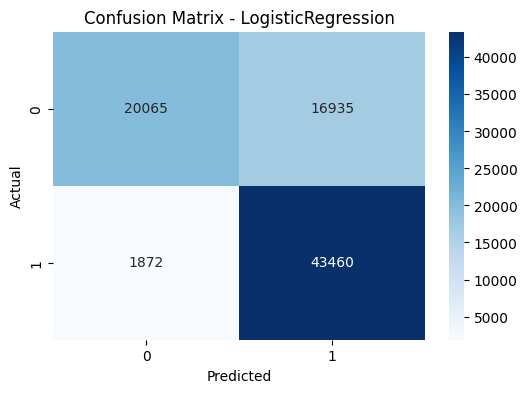

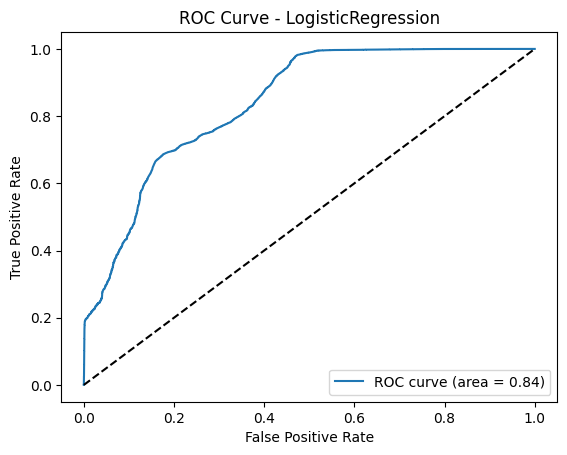

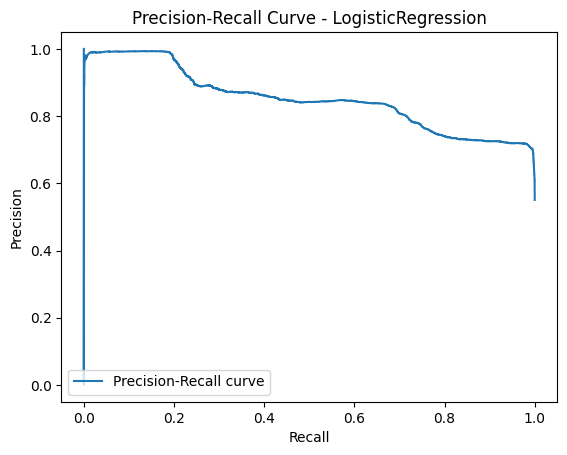

(0.7715711995335957,
 0.9587046677843466,
 0.7195959930457819,
 0.8221173399415476,
 0.9587046677843466,
 0.5422972972972973)

In [ ]:
# Create a pipeline for scaling and training LinearSVC
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardizes features by removing the mean and scaling to unit variance
    ('lr', LogisticRegression(max_iter=1000))  # Logistic Regression model
])

# Fit the model
lr_pipeline.fit(X_train, y_train)

# Evaluate the model
evaluate_model(lr_pipeline, X_test, y_test, "LogisticRegression")

### SVM(Support Vector Machines)

/Users/hepplexi/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:304: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


=== SVM ===
Accuracy: 0.7494
Recall: 0.8637
Precision: 0.7303
F1-Score: 0.7915
Sensitivity: 0.8637
Specificity: 0.6093

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.61      0.69     37000
           1       0.73      0.86      0.79     45332

    accuracy                           0.75     82332
   macro avg       0.76      0.74      0.74     82332
weighted avg       0.75      0.75      0.74     82332



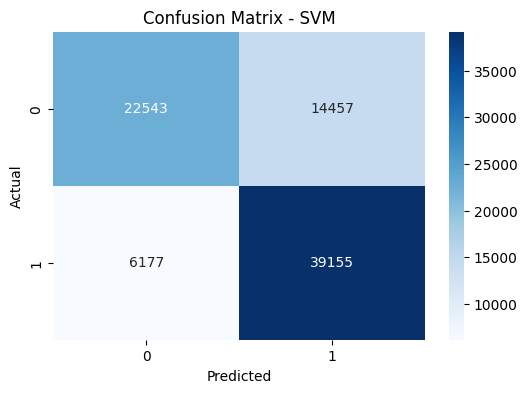

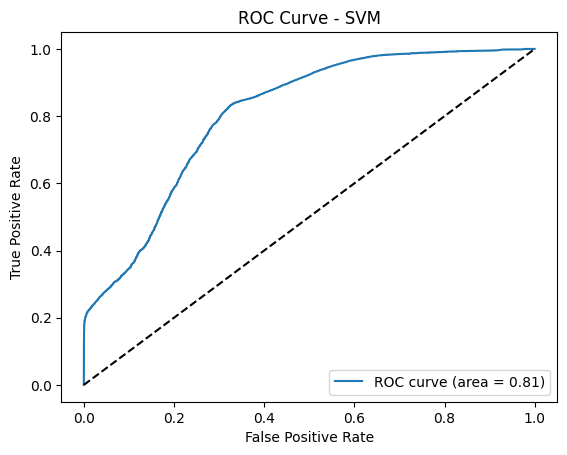

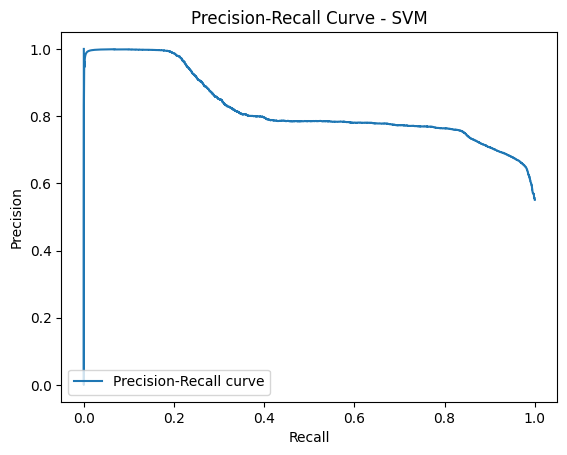

(0.7493805567701501,
 0.8637386393717462,
 0.7303402223382824,
 0.7914577943078913,
 0.8637386393717462,
 0.6092702702702703)

In [32]:
# Create a pipeline for scaling and training LinearSVC
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardizes features by removing the mean and scaling to unit variance
    ('svm', SVC(kernel="linear", class_weight="balanced", max_iter=10000))  # LinearSVC with balanced class weights
])

# Fit the model
svm_pipeline.fit(X_train, y_train)

# Evaluate the model
evaluate_model(svm_pipeline, X_test, y_test, "SVM")

### Random Forest

=== Random Forest ===
Accuracy: 0.8620
Recall: 0.9859
Precision: 0.8066
F1-Score: 0.8873
Sensitivity: 0.9859
Specificity: 0.7103

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.71      0.82     37000
           1       0.81      0.99      0.89     45332

    accuracy                           0.86     82332
   macro avg       0.89      0.85      0.85     82332
weighted avg       0.88      0.86      0.86     82332



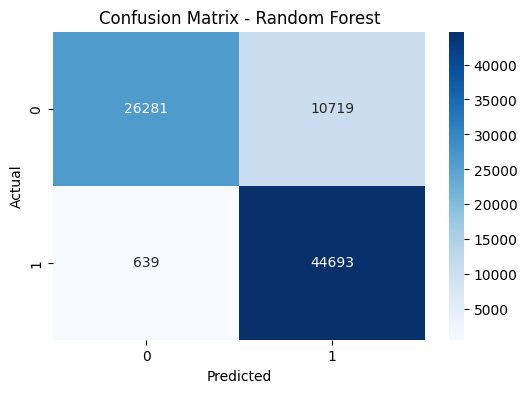

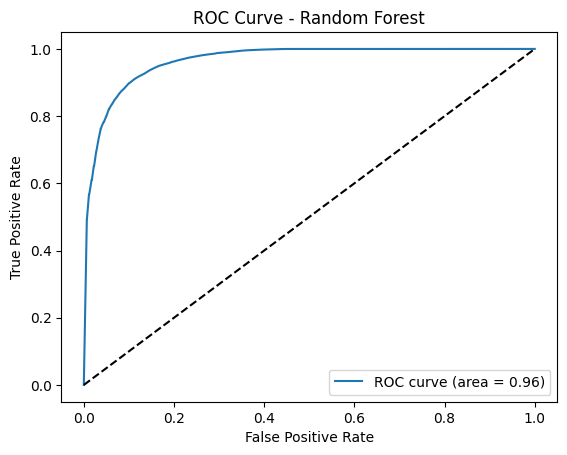

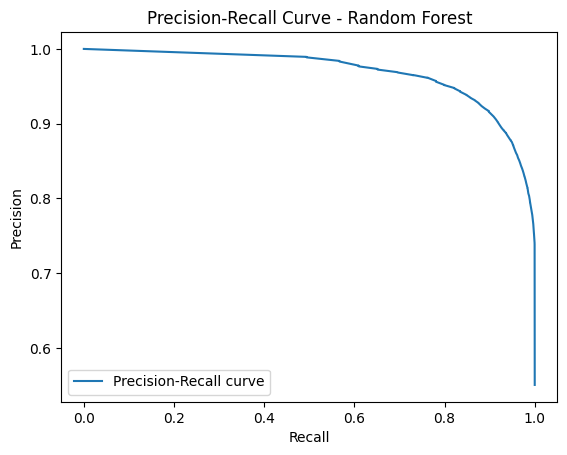

(0.8620463489287276,
 0.9859039971763875,
 0.8065581462499097,
 0.8872587945684111,
 0.9859039971763875,
 0.7102972972972973)

In [33]:
rf_model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=27)
rf_model.fit(X_train, y_train)
evaluate_model(rf_model, X_test, y_test, "Random Forest")

### XGBoost

=== XGBoost ===
Accuracy: 0.8957
Recall: 0.9597
Precision: 0.8655
F1-Score: 0.9102
Sensitivity: 0.9597
Specificity: 0.8172

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.82      0.88     37000
           1       0.87      0.96      0.91     45332

    accuracy                           0.90     82332
   macro avg       0.90      0.89      0.89     82332
weighted avg       0.90      0.90      0.89     82332



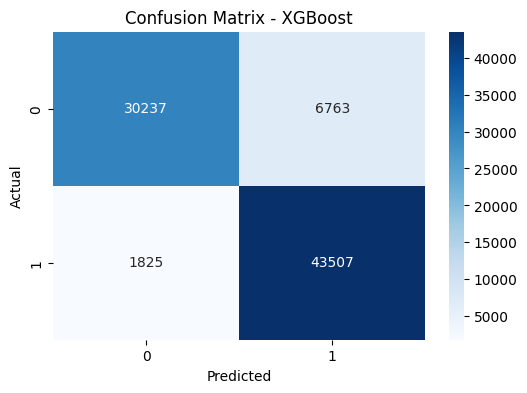

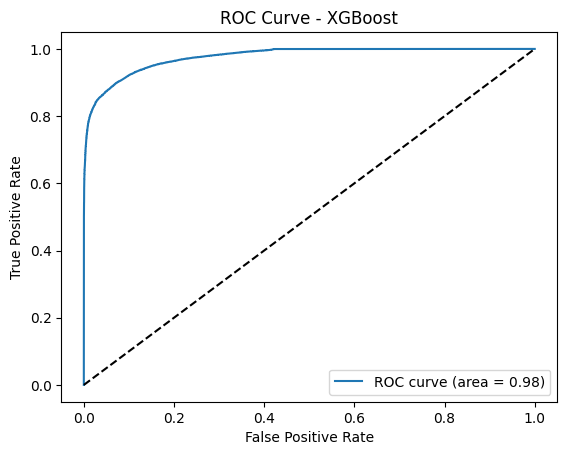

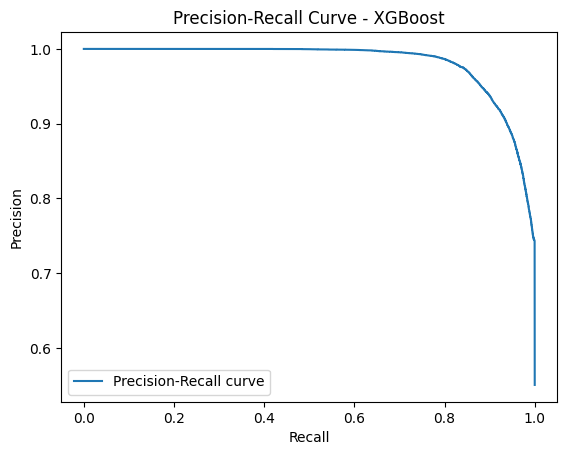

(0.8956906184715542,
 0.9597414629842054,
 0.865466481002586,
 0.9101692433212695,
 0.9597414629842054,
 0.8172162162162162)

In [34]:
ratio = float(y_train.value_counts()[0]) / y_train.value_counts()[1]
xgb_model = XGBClassifier(scale_pos_weight=ratio, random_state=27)
xgb_model.fit(X_train, y_train)
evaluate_model(xgb_model, X_test, y_test, "XGBoost")

### Neural Network

Epoch 1/200
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 4s 712us/step - accuracy: 0.6634 - auc_6: 0.7696 - loss: 0.0468 - precision_6: 0.8656 - recall_6: 0.5256 - val_accuracy: 0.8776 - val_auc_6: 0.0000e+00 - val_loss: 0.0194 - val_precision_6: 1.0000 - val_recall_6: 0.8776
Epoch 2/200
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 3s 668us/step - accuracy: 0.7046 - auc_6: 0.8548 - loss: 0.0342 - precision_6: 0.9110 - recall_6: 0.5619 - val_accuracy: 0.8641 - val_auc_6: 0.0000e+00 - val_loss: 0.0239 - val_precision_6: 1.0000 - val_recall_6: 0.8641
Epoch 3/200
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 3s 674us/step - accuracy: 0.7145 - auc_6: 0.8725 - loss: 0.0322 - precision_6: 0.9132 - recall_6: 0.5811 - val_accuracy: 0.8400 - val_auc_6: 0.0000e+00 - val_loss: 0.0183 - val_precision_6: 1.0000 - val_recall_6: 0.8400
Epoch 4/200
4384/4384 ━━━━━━━━━━━━━━━━━━━━ 3s 665us/step - accuracy: 0.7145 - auc_6: 0.8797 - loss: 0.0315 - precision_6: 0.9131 - recall_6: 0.5799 - val_accuracy: 0.8789 - val_auc_6: 0.0000e+00 - val_loss: 0.01

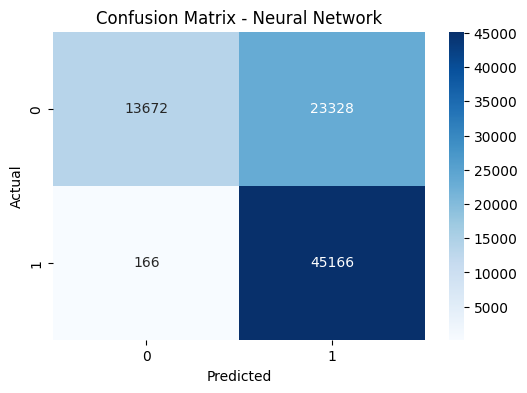

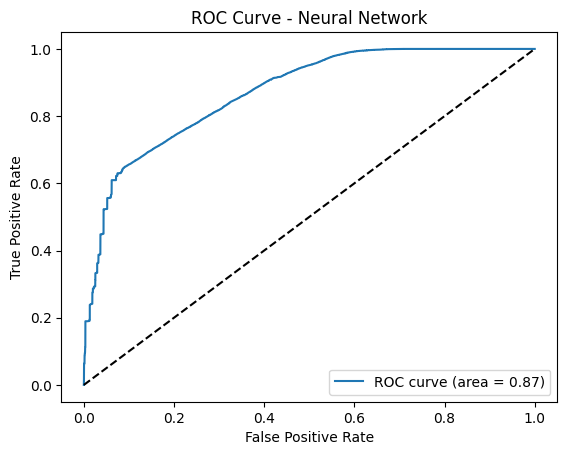

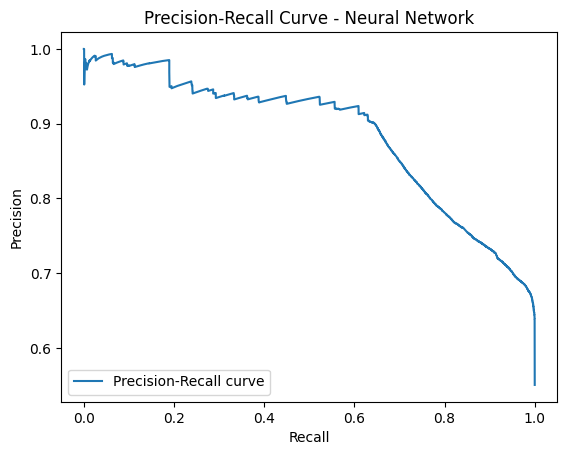

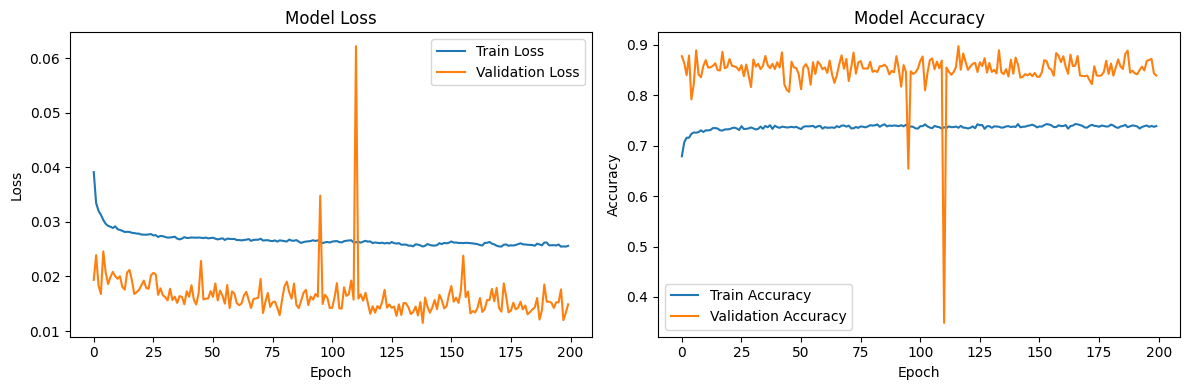

In [48]:
n_samples = len(y_train)
n_positive = sum(y_train)
ratio = (n_samples - n_positive) / n_positive
class_weight = {0: 1, 1: ratio}

def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

tf_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),  # Increase first layer size
    BatchNormalization(),  # Add batch normalization
    Dropout(0.3),  # Add dropout for regularization
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=focal_loss(),
    metrics=['accuracy', AUC(), Precision(), Recall()]
)

history = tf_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=200,  
    validation_split=0.2,
    class_weight=class_weight,
    verbose=1
)

evaluate_model(tf_model, X_test, y_test, "Neural Network")

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Neural Network_Pytorch

In [15]:
# Pytorch
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy

Epoch [1/200], Train Acc: 0.7617, Val Acc: 0.7108


Epoch [2/200], Train Acc: 0.8012, Val Acc: 0.6478


Epoch [3/200], Train Acc: 0.8090, Val Acc: 0.7204


Epoch [4/200], Train Acc: 0.8150, Val Acc: 0.7171


Epoch [5/200], Train Acc: 0.8182, Val Acc: 0.6899


Epoch [6/200], Train Acc: 0.8232, Val Acc: 0.7161


Epoch [7/200], Train Acc: 0.8251, Val Acc: 0.7196


Epoch [8/200], Train Acc: 0.8276, Val Acc: 0.6630


Epoch [9/200], Train Acc: 0.8289, Val Acc: 0.6995


Epoch [10/200], Train Acc: 0.8306, Val Acc: 0.7050


Epoch [11/200], Train Acc: 0.8319, Val Acc: 0.7294


Epoch [12/200], Train Acc: 0.8328, Val Acc: 0.7031


Epoch [13/200], Train Acc: 0.8334, Val Acc: 0.6936


Epoch [14/200], Train Acc: 0.8345, Val Acc: 0.7143


Epoch [15/200], Train Acc: 0.8353, Val Acc: 0.6981


Epoch [16/200], Train Acc: 0.8348, Val Acc: 0.7067


Epoch [17/200], Train Acc: 0.8354, Val Acc: 0.7175


Epoch [18/200], Train Acc: 0.8370, Val Acc: 0.6454


Epoch [19/200], Train Acc: 0.8370, Val Acc: 0.7174


Epoch [20/200], Train Acc: 0.8374, Val Acc: 0.7190


Epoch [21/200], Train Acc: 0.8379, Val Acc: 0.7180


Epoch [22/200], Train Acc: 0.8376, Val Acc: 0.7183


Epoch [23/200], Train Acc: 0.8384, Val Acc: 0.7204


Epoch [24/200], Train Acc: 0.8389, Val Acc: 0.7066


Epoch [25/200], Train Acc: 0.8384, Val Acc: 0.7072


Epoch [26/200], Train Acc: 0.8402, Val Acc: 0.7101


Epoch [27/200], Train Acc: 0.8402, Val Acc: 0.7246


Epoch [28/200], Train Acc: 0.8414, Val Acc: 0.7222


Epoch [29/200], Train Acc: 0.8407, Val Acc: 0.7236


Epoch [30/200], Train Acc: 0.8404, Val Acc: 0.7143


Epoch [31/200], Train Acc: 0.8411, Val Acc: 0.7112


Epoch [32/200], Train Acc: 0.8418, Val Acc: 0.7284


Epoch [33/200], Train Acc: 0.8424, Val Acc: 0.6985


Epoch [34/200], Train Acc: 0.8427, Val Acc: 0.7136


Epoch [35/200], Train Acc: 0.8422, Val Acc: 0.7138


Epoch [36/200], Train Acc: 0.8427, Val Acc: 0.7284


Epoch [37/200], Train Acc: 0.8436, Val Acc: 0.7234


Epoch [38/200], Train Acc: 0.8432, Val Acc: 0.7161


Epoch [39/200], Train Acc: 0.8424, Val Acc: 0.6519


Epoch [40/200], Train Acc: 0.8436, Val Acc: 0.7295


Epoch [41/200], Train Acc: 0.8442, Val Acc: 0.7402


Epoch [42/200], Train Acc: 0.8449, Val Acc: 0.7256


Epoch [43/200], Train Acc: 0.8445, Val Acc: 0.7261


Epoch [44/200], Train Acc: 0.8461, Val Acc: 0.6679


Epoch [45/200], Train Acc: 0.8462, Val Acc: 0.7319


Epoch [46/200], Train Acc: 0.8457, Val Acc: 0.7079


Epoch [47/200], Train Acc: 0.8453, Val Acc: 0.7193


Epoch [48/200], Train Acc: 0.8462, Val Acc: 0.7339


Epoch [49/200], Train Acc: 0.8463, Val Acc: 0.7221


Epoch [50/200], Train Acc: 0.8472, Val Acc: 0.7428


Epoch [51/200], Train Acc: 0.8472, Val Acc: 0.7150


Epoch [52/200], Train Acc: 0.8478, Val Acc: 0.7303


Epoch [53/200], Train Acc: 0.8479, Val Acc: 0.6642


Epoch [54/200], Train Acc: 0.8483, Val Acc: 0.7429


Epoch [55/200], Train Acc: 0.8475, Val Acc: 0.7211


Epoch [56/200], Train Acc: 0.8484, Val Acc: 0.7264


Epoch [57/200], Train Acc: 0.8474, Val Acc: 0.7310


Epoch [58/200], Train Acc: 0.8479, Val Acc: 0.7410


Epoch [59/200], Train Acc: 0.8481, Val Acc: 0.7250


Epoch [60/200], Train Acc: 0.8491, Val Acc: 0.7359


Epoch [61/200], Train Acc: 0.8505, Val Acc: 0.7226


Epoch [62/200], Train Acc: 0.8497, Val Acc: 0.7425


Epoch [63/200], Train Acc: 0.8495, Val Acc: 0.7448


Epoch [64/200], Train Acc: 0.8498, Val Acc: 0.7357


Epoch [65/200], Train Acc: 0.8497, Val Acc: 0.7304


Epoch [66/200], Train Acc: 0.8503, Val Acc: 0.7319


Epoch [67/200], Train Acc: 0.8516, Val Acc: 0.6678


Epoch [68/200], Train Acc: 0.8514, Val Acc: 0.6566


Epoch [69/200], Train Acc: 0.8518, Val Acc: 0.7453


Epoch [70/200], Train Acc: 0.8517, Val Acc: 0.7339


Epoch [71/200], Train Acc: 0.8509, Val Acc: 0.7321


Epoch [72/200], Train Acc: 0.8522, Val Acc: 0.7388


Epoch [73/200], Train Acc: 0.8519, Val Acc: 0.7461


Epoch [74/200], Train Acc: 0.8508, Val Acc: 0.7298


Epoch [75/200], Train Acc: 0.8518, Val Acc: 0.7368


Epoch [76/200], Train Acc: 0.8513, Val Acc: 0.7470


Epoch [77/200], Train Acc: 0.8511, Val Acc: 0.6577


Epoch [78/200], Train Acc: 0.8520, Val Acc: 0.7454


Epoch [79/200], Train Acc: 0.8507, Val Acc: 0.7411


Epoch [80/200], Train Acc: 0.8521, Val Acc: 0.7404


Epoch [81/200], Train Acc: 0.8519, Val Acc: 0.6564


Epoch [82/200], Train Acc: 0.8523, Val Acc: 0.7301


Epoch [83/200], Train Acc: 0.8533, Val Acc: 0.7466


Epoch [84/200], Train Acc: 0.8520, Val Acc: 0.7441


Epoch [85/200], Train Acc: 0.8532, Val Acc: 0.7208


Epoch [86/200], Train Acc: 0.8534, Val Acc: 0.7112


Epoch [87/200], Train Acc: 0.8525, Val Acc: 0.7426


Epoch [88/200], Train Acc: 0.8544, Val Acc: 0.7344


Epoch [89/200], Train Acc: 0.8529, Val Acc: 0.7345


Epoch [90/200], Train Acc: 0.8532, Val Acc: 0.7340


Epoch [91/200], Train Acc: 0.8542, Val Acc: 0.7360


Epoch [92/200], Train Acc: 0.8537, Val Acc: 0.7333


Epoch [93/200], Train Acc: 0.8546, Val Acc: 0.7381


Epoch [94/200], Train Acc: 0.8536, Val Acc: 0.7407


Epoch [95/200], Train Acc: 0.8528, Val Acc: 0.7305


Epoch [96/200], Train Acc: 0.8537, Val Acc: 0.7394


Epoch [97/200], Train Acc: 0.8524, Val Acc: 0.7427


Epoch [98/200], Train Acc: 0.8532, Val Acc: 0.7443


Epoch [99/200], Train Acc: 0.8541, Val Acc: 0.7390


Epoch [100/200], Train Acc: 0.8544, Val Acc: 0.7289


Epoch [101/200], Train Acc: 0.8551, Val Acc: 0.7413


Epoch [102/200], Train Acc: 0.8556, Val Acc: 0.7405


Epoch [103/200], Train Acc: 0.8540, Val Acc: 0.7316


Epoch [104/200], Train Acc: 0.8547, Val Acc: 0.7464


Epoch [105/200], Train Acc: 0.8540, Val Acc: 0.7362


Epoch [106/200], Train Acc: 0.8558, Val Acc: 0.7381


Epoch [107/200], Train Acc: 0.8545, Val Acc: 0.7408


Epoch [108/200], Train Acc: 0.8543, Val Acc: 0.7360


Epoch [109/200], Train Acc: 0.8551, Val Acc: 0.7433


Epoch [110/200], Train Acc: 0.8549, Val Acc: 0.7286


Epoch [111/200], Train Acc: 0.8547, Val Acc: 0.7415


Epoch [112/200], Train Acc: 0.8553, Val Acc: 0.7267


Epoch [113/200], Train Acc: 0.8553, Val Acc: 0.7377


Epoch [114/200], Train Acc: 0.8560, Val Acc: 0.7408


Epoch [115/200], Train Acc: 0.8557, Val Acc: 0.7451


Epoch [116/200], Train Acc: 0.8557, Val Acc: 0.7229


Epoch [117/200], Train Acc: 0.8553, Val Acc: 0.7360


Epoch [118/200], Train Acc: 0.8547, Val Acc: 0.7348


Epoch [119/200], Train Acc: 0.8558, Val Acc: 0.7324


Epoch [120/200], Train Acc: 0.8555, Val Acc: 0.7443


Epoch [121/200], Train Acc: 0.8559, Val Acc: 0.7369


Epoch [122/200], Train Acc: 0.8564, Val Acc: 0.7230


Epoch [123/200], Train Acc: 0.8547, Val Acc: 0.6584


Epoch [124/200], Train Acc: 0.8551, Val Acc: 0.7423


Epoch [125/200], Train Acc: 0.8558, Val Acc: 0.7437


Epoch [126/200], Train Acc: 0.8561, Val Acc: 0.7456


Epoch [127/200], Train Acc: 0.8562, Val Acc: 0.7447


Epoch [128/200], Train Acc: 0.8564, Val Acc: 0.7403


Epoch [129/200], Train Acc: 0.8571, Val Acc: 0.7423


Epoch [130/200], Train Acc: 0.8571, Val Acc: 0.7421


Epoch [131/200], Train Acc: 0.8563, Val Acc: 0.7351


Epoch [132/200], Train Acc: 0.8560, Val Acc: 0.7483


Epoch [133/200], Train Acc: 0.8574, Val Acc: 0.7501


Epoch [134/200], Train Acc: 0.8566, Val Acc: 0.7398


Epoch [135/200], Train Acc: 0.8569, Val Acc: 0.7370


Epoch [136/200], Train Acc: 0.8560, Val Acc: 0.7398


Epoch [137/200], Train Acc: 0.8571, Val Acc: 0.7404


Epoch [138/200], Train Acc: 0.8571, Val Acc: 0.7453


Epoch [139/200], Train Acc: 0.8562, Val Acc: 0.7344


Epoch [140/200], Train Acc: 0.8575, Val Acc: 0.7127


Epoch [141/200], Train Acc: 0.8563, Val Acc: 0.7430


Epoch [142/200], Train Acc: 0.8568, Val Acc: 0.7446


Epoch [143/200], Train Acc: 0.8567, Val Acc: 0.7318


Epoch [144/200], Train Acc: 0.8577, Val Acc: 0.7214


Epoch [145/200], Train Acc: 0.8577, Val Acc: 0.7451


Epoch [146/200], Train Acc: 0.8568, Val Acc: 0.7135


Epoch [147/200], Train Acc: 0.8574, Val Acc: 0.7410


Epoch [148/200], Train Acc: 0.8574, Val Acc: 0.7405


Epoch [149/200], Train Acc: 0.8563, Val Acc: 0.6575


Epoch [150/200], Train Acc: 0.8576, Val Acc: 0.7371


Epoch [151/200], Train Acc: 0.8571, Val Acc: 0.7301


Epoch [152/200], Train Acc: 0.8567, Val Acc: 0.7343


Epoch [153/200], Train Acc: 0.8569, Val Acc: 0.7465


Epoch [154/200], Train Acc: 0.8576, Val Acc: 0.7416


Epoch [155/200], Train Acc: 0.8577, Val Acc: 0.7424


Epoch [156/200], Train Acc: 0.8575, Val Acc: 0.7453


Epoch [157/200], Train Acc: 0.8573, Val Acc: 0.7427


Epoch [158/200], Train Acc: 0.8573, Val Acc: 0.7461


Epoch [159/200], Train Acc: 0.8572, Val Acc: 0.7389


Epoch [160/200], Train Acc: 0.8574, Val Acc: 0.7420


Epoch [161/200], Train Acc: 0.8579, Val Acc: 0.7461


Epoch [162/200], Train Acc: 0.8572, Val Acc: 0.7399


Epoch [163/200], Train Acc: 0.8573, Val Acc: 0.7477


Epoch [164/200], Train Acc: 0.8576, Val Acc: 0.7477


Epoch [165/200], Train Acc: 0.8581, Val Acc: 0.7451


Epoch [166/200], Train Acc: 0.8580, Val Acc: 0.7415


Epoch [167/200], Train Acc: 0.8583, Val Acc: 0.7461


Epoch [168/200], Train Acc: 0.8575, Val Acc: 0.7442


Epoch [169/200], Train Acc: 0.8571, Val Acc: 0.7445


Epoch [170/200], Train Acc: 0.8571, Val Acc: 0.7425


Epoch [171/200], Train Acc: 0.8577, Val Acc: 0.7457


Epoch [172/200], Train Acc: 0.8572, Val Acc: 0.7439


Epoch [173/200], Train Acc: 0.8580, Val Acc: 0.7404


Epoch [174/200], Train Acc: 0.8579, Val Acc: 0.7459


Epoch [175/200], Train Acc: 0.8576, Val Acc: 0.7452


Epoch [176/200], Train Acc: 0.8573, Val Acc: 0.7487


Epoch [177/200], Train Acc: 0.8580, Val Acc: 0.7268


Epoch [178/200], Train Acc: 0.8585, Val Acc: 0.7457


Epoch [179/200], Train Acc: 0.8575, Val Acc: 0.7357


Epoch [180/200], Train Acc: 0.8569, Val Acc: 0.7488


Epoch [181/200], Train Acc: 0.8579, Val Acc: 0.7391


Epoch [182/200], Train Acc: 0.8584, Val Acc: 0.7468


Epoch [183/200], Train Acc: 0.8582, Val Acc: 0.7455


Epoch [184/200], Train Acc: 0.8583, Val Acc: 0.7483


Epoch [185/200], Train Acc: 0.8582, Val Acc: 0.7434


Epoch [186/200], Train Acc: 0.8584, Val Acc: 0.7384


Epoch [187/200], Train Acc: 0.8580, Val Acc: 0.7449


Epoch [188/200], Train Acc: 0.8582, Val Acc: 0.7439


Epoch [189/200], Train Acc: 0.8584, Val Acc: 0.7309


Epoch [190/200], Train Acc: 0.8584, Val Acc: 0.7408


Epoch [191/200], Train Acc: 0.8578, Val Acc: 0.7435


Epoch [192/200], Train Acc: 0.8586, Val Acc: 0.7436


Epoch [193/200], Train Acc: 0.8587, Val Acc: 0.7445


Epoch [194/200], Train Acc: 0.8591, Val Acc: 0.7393


Epoch [195/200], Train Acc: 0.8585, Val Acc: 0.7300


Epoch [196/200], Train Acc: 0.8579, Val Acc: 0.7467


Epoch [197/200], Train Acc: 0.8583, Val Acc: 0.7378


Epoch [198/200], Train Acc: 0.8587, Val Acc: 0.7480


Epoch [199/200], Train Acc: 0.8577, Val Acc: 0.7419


Epoch [200/200], Train Acc: 0.8585, Val Acc: 0.7403
=== Neural_Network_PyTorch ===
Accuracy: 0.7501
Recall: 0.9032
Precision: 0.7167
F1-Score: 0.7992
Sensitivity: 0.9032
Specificity: 0.5625

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.56      0.67     37000
           1       0.72      0.90      0.80     45332

    accuracy                           0.75     82332
   macro avg       0.77      0.73      0.73     82332
weighted avg       0.77      0.75      0.74     82332



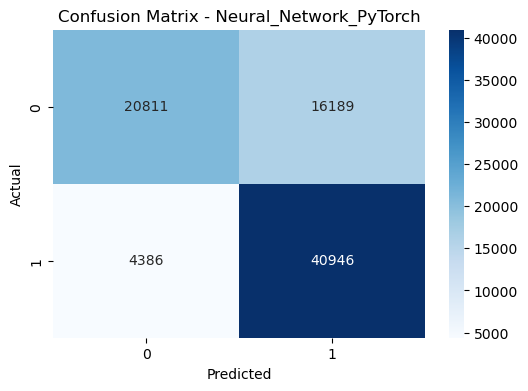

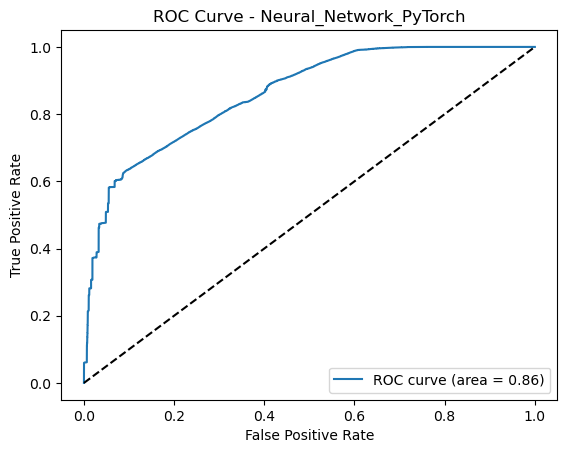

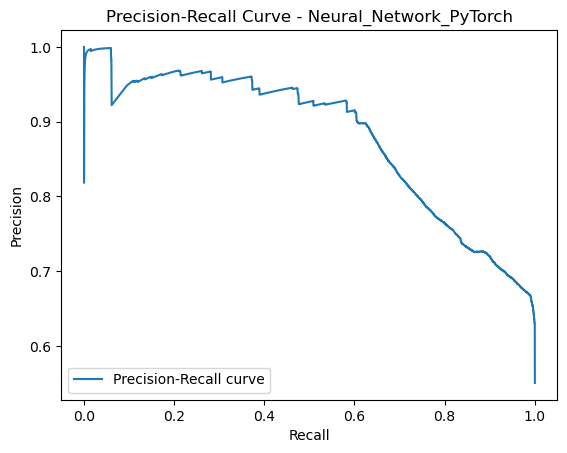

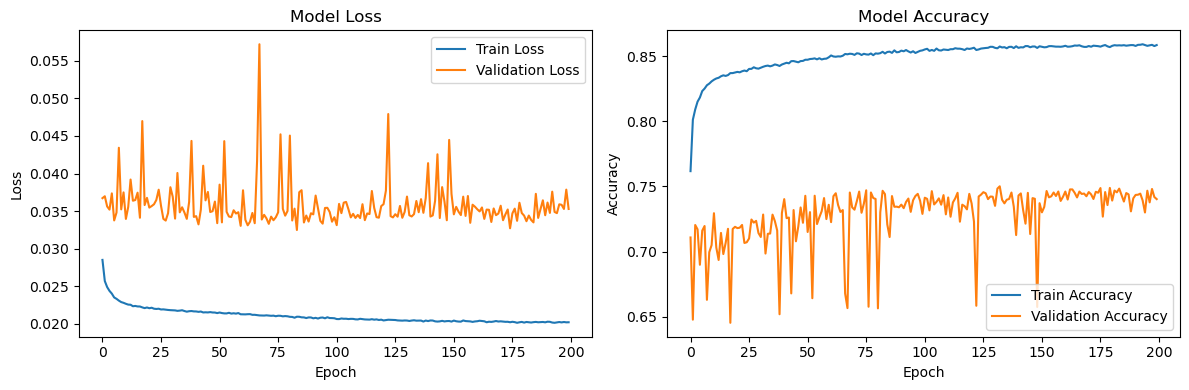

In [16]:
model_name = "Neural_Network_PyTorch"
def focal_loss(alpha=0.25, gamma=2.0):
    def loss_fn(inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        p_t = torch.exp(-bce_loss)
        loss = alpha * (1 - p_t) ** gamma * bce_loss
        return loss.mean()
    return loss_fn

class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

def prepare_dataloader(X, y, batch_size=32):
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = prepare_dataloader(X_train, y_train)
val_loader = prepare_dataloader(X_test, y_test)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralNetwork(input_size=X_train.shape[1]).to(device)

loss_fn = focal_loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loss = []
val_loss_history = []
train_accuracy = []
val_accuracy = []

best_val_acc = 0.0
best_model_state = None

epochs = 200
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        predictions = (torch.sigmoid(outputs) > 0.5).float()
        correct += (predictions == y_batch).sum().item()
        total += y_batch.size(0)
    
    train_loss.append(total_loss / len(train_loader))
    train_acc = correct / total
    train_accuracy.append(train_acc)
    
    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_outputs = model(X_val)
            total_val_loss += loss_fn(val_outputs, y_val).item()
            
            predictions = (torch.sigmoid(val_outputs) > 0.5).float()
            correct += (predictions == y_val).sum().item()
            total += y_val.size(0)
    
    val_loss_history.append(total_val_loss / len(val_loader))
    val_acc = correct / total
    val_accuracy.append(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
    
    print(f"Epoch [{epoch+1}/{epochs}], Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Load the best model
model.load_state_dict(best_model_state)
model.eval()
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
with torch.no_grad():
    y_prob = torch.sigmoid(model(X_test_tensor).squeeze()).cpu().numpy()
    y_pred = (y_prob > 0.5).astype(int)

# Compute metrics
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Print metrics
print(f"=== {model_name} ===")
print(f"Accuracy: {acc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title(f"ROC Curve - {model_name}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
plt.figure()
plt.plot(recall_vals, precision_vals, label="Precision-Recall curve")
plt.title(f"Precision-Recall Curve - {model_name}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [17]:
class CNNNetwork(nn.Module):
    def __init__(self, input_size):
        super(CNNNetwork, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc = nn.Linear(64 * input_size, 1)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = x.unsqueeze(1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

Epoch [1/200], Train Acc: 0.7735, Val Acc: 0.7085


Epoch [2/200], Train Acc: 0.8188, Val Acc: 0.7145


Epoch [3/200], Train Acc: 0.8280, Val Acc: 0.7269


Epoch [4/200], Train Acc: 0.8319, Val Acc: 0.7393


Epoch [5/200], Train Acc: 0.8347, Val Acc: 0.7423


Epoch [6/200], Train Acc: 0.8369, Val Acc: 0.7453


Epoch [7/200], Train Acc: 0.8385, Val Acc: 0.7362


Epoch [8/200], Train Acc: 0.8402, Val Acc: 0.7460


Epoch [9/200], Train Acc: 0.8422, Val Acc: 0.7433


Epoch [10/200], Train Acc: 0.8423, Val Acc: 0.7455


Epoch [11/200], Train Acc: 0.8428, Val Acc: 0.7440


Epoch [12/200], Train Acc: 0.8440, Val Acc: 0.7452


Epoch [13/200], Train Acc: 0.8443, Val Acc: 0.7468


Epoch [14/200], Train Acc: 0.8452, Val Acc: 0.7461


Epoch [15/200], Train Acc: 0.8458, Val Acc: 0.7418


Epoch [16/200], Train Acc: 0.8447, Val Acc: 0.7442


Epoch [17/200], Train Acc: 0.8461, Val Acc: 0.7470


Epoch [18/200], Train Acc: 0.8460, Val Acc: 0.7422


Epoch [19/200], Train Acc: 0.8463, Val Acc: 0.7411


Epoch [20/200], Train Acc: 0.8471, Val Acc: 0.7477


Epoch [21/200], Train Acc: 0.8482, Val Acc: 0.7461


Epoch [22/200], Train Acc: 0.8475, Val Acc: 0.7443


Epoch [23/200], Train Acc: 0.8474, Val Acc: 0.7469


Epoch [24/200], Train Acc: 0.8483, Val Acc: 0.7466


Epoch [25/200], Train Acc: 0.8484, Val Acc: 0.7456


Epoch [26/200], Train Acc: 0.8486, Val Acc: 0.7456


Epoch [27/200], Train Acc: 0.8486, Val Acc: 0.7462


Epoch [28/200], Train Acc: 0.8484, Val Acc: 0.7454


Epoch [29/200], Train Acc: 0.8495, Val Acc: 0.7444


Epoch [30/200], Train Acc: 0.8492, Val Acc: 0.7462


Epoch [31/200], Train Acc: 0.8496, Val Acc: 0.7471


Epoch [32/200], Train Acc: 0.8488, Val Acc: 0.7439


Epoch [33/200], Train Acc: 0.8495, Val Acc: 0.7460


Epoch [34/200], Train Acc: 0.8492, Val Acc: 0.7459


Epoch [35/200], Train Acc: 0.8494, Val Acc: 0.7463


Epoch [36/200], Train Acc: 0.8495, Val Acc: 0.7453


Epoch [37/200], Train Acc: 0.8500, Val Acc: 0.7471


Epoch [38/200], Train Acc: 0.8499, Val Acc: 0.7475


Epoch [39/200], Train Acc: 0.8491, Val Acc: 0.7465


Epoch [40/200], Train Acc: 0.8504, Val Acc: 0.7456


Epoch [41/200], Train Acc: 0.8497, Val Acc: 0.7469


Epoch [42/200], Train Acc: 0.8510, Val Acc: 0.7472


Epoch [43/200], Train Acc: 0.8509, Val Acc: 0.7459


Epoch [44/200], Train Acc: 0.8501, Val Acc: 0.7471


Epoch [45/200], Train Acc: 0.8507, Val Acc: 0.7443


Epoch [46/200], Train Acc: 0.8508, Val Acc: 0.7474


Epoch [47/200], Train Acc: 0.8509, Val Acc: 0.7469


Epoch [48/200], Train Acc: 0.8506, Val Acc: 0.7464


Epoch [49/200], Train Acc: 0.8507, Val Acc: 0.7459


Epoch [50/200], Train Acc: 0.8506, Val Acc: 0.7447


Epoch [51/200], Train Acc: 0.8507, Val Acc: 0.7452


Epoch [52/200], Train Acc: 0.8509, Val Acc: 0.7475


Epoch [53/200], Train Acc: 0.8516, Val Acc: 0.7458


Epoch [54/200], Train Acc: 0.8516, Val Acc: 0.7474


Epoch [55/200], Train Acc: 0.8519, Val Acc: 0.7476


Epoch [56/200], Train Acc: 0.8513, Val Acc: 0.7466


Epoch [57/200], Train Acc: 0.8515, Val Acc: 0.7473


Epoch [58/200], Train Acc: 0.8516, Val Acc: 0.7478


Epoch [59/200], Train Acc: 0.8514, Val Acc: 0.7480


Epoch [60/200], Train Acc: 0.8514, Val Acc: 0.7476


Epoch [61/200], Train Acc: 0.8518, Val Acc: 0.7461


Epoch [62/200], Train Acc: 0.8519, Val Acc: 0.7443


Epoch [63/200], Train Acc: 0.8506, Val Acc: 0.7472


Epoch [64/200], Train Acc: 0.8517, Val Acc: 0.7477


Epoch [65/200], Train Acc: 0.8511, Val Acc: 0.7479


Epoch [66/200], Train Acc: 0.8525, Val Acc: 0.7441


Epoch [67/200], Train Acc: 0.8517, Val Acc: 0.7457


Epoch [68/200], Train Acc: 0.8518, Val Acc: 0.7454


Epoch [69/200], Train Acc: 0.8519, Val Acc: 0.7488


Epoch [70/200], Train Acc: 0.8519, Val Acc: 0.7470


Epoch [71/200], Train Acc: 0.8516, Val Acc: 0.7442


Epoch [72/200], Train Acc: 0.8520, Val Acc: 0.7476


Epoch [73/200], Train Acc: 0.8521, Val Acc: 0.7458


Epoch [74/200], Train Acc: 0.8528, Val Acc: 0.7476


Epoch [75/200], Train Acc: 0.8524, Val Acc: 0.7412


Epoch [76/200], Train Acc: 0.8517, Val Acc: 0.7471


Epoch [77/200], Train Acc: 0.8529, Val Acc: 0.7468


Epoch [78/200], Train Acc: 0.8526, Val Acc: 0.7477


Epoch [79/200], Train Acc: 0.8517, Val Acc: 0.7466


Epoch [80/200], Train Acc: 0.8524, Val Acc: 0.7475


Epoch [81/200], Train Acc: 0.8523, Val Acc: 0.7477


Epoch [82/200], Train Acc: 0.8530, Val Acc: 0.7461


Epoch [83/200], Train Acc: 0.8529, Val Acc: 0.7444


Epoch [84/200], Train Acc: 0.8524, Val Acc: 0.7475


Epoch [85/200], Train Acc: 0.8521, Val Acc: 0.7474


Epoch [86/200], Train Acc: 0.8528, Val Acc: 0.7454


Epoch [87/200], Train Acc: 0.8525, Val Acc: 0.7469


Epoch [88/200], Train Acc: 0.8522, Val Acc: 0.7469


Epoch [89/200], Train Acc: 0.8526, Val Acc: 0.7486


Epoch [90/200], Train Acc: 0.8528, Val Acc: 0.7487


Epoch [91/200], Train Acc: 0.8532, Val Acc: 0.7469


Epoch [92/200], Train Acc: 0.8538, Val Acc: 0.7438


Epoch [93/200], Train Acc: 0.8524, Val Acc: 0.7457


Epoch [94/200], Train Acc: 0.8528, Val Acc: 0.7457


Epoch [95/200], Train Acc: 0.8534, Val Acc: 0.7476


Epoch [96/200], Train Acc: 0.8525, Val Acc: 0.7480


Epoch [97/200], Train Acc: 0.8527, Val Acc: 0.7465


Epoch [98/200], Train Acc: 0.8529, Val Acc: 0.7458


Epoch [99/200], Train Acc: 0.8531, Val Acc: 0.7472


Epoch [100/200], Train Acc: 0.8532, Val Acc: 0.7472


Epoch [101/200], Train Acc: 0.8531, Val Acc: 0.7478


Epoch [102/200], Train Acc: 0.8527, Val Acc: 0.7465


Epoch [103/200], Train Acc: 0.8524, Val Acc: 0.7463


Epoch [104/200], Train Acc: 0.8531, Val Acc: 0.7477


Epoch [105/200], Train Acc: 0.8537, Val Acc: 0.7458


Epoch [106/200], Train Acc: 0.8539, Val Acc: 0.7432


Epoch [107/200], Train Acc: 0.8533, Val Acc: 0.7478


Epoch [108/200], Train Acc: 0.8525, Val Acc: 0.7476


Epoch [109/200], Train Acc: 0.8531, Val Acc: 0.7456


Epoch [110/200], Train Acc: 0.8535, Val Acc: 0.7477


Epoch [111/200], Train Acc: 0.8534, Val Acc: 0.7473


Epoch [112/200], Train Acc: 0.8538, Val Acc: 0.7475


Epoch [113/200], Train Acc: 0.8534, Val Acc: 0.7451


Epoch [114/200], Train Acc: 0.8541, Val Acc: 0.7452


Epoch [115/200], Train Acc: 0.8530, Val Acc: 0.7462


Epoch [116/200], Train Acc: 0.8533, Val Acc: 0.7462


Epoch [117/200], Train Acc: 0.8538, Val Acc: 0.7460


Epoch [118/200], Train Acc: 0.8533, Val Acc: 0.7474


Epoch [119/200], Train Acc: 0.8539, Val Acc: 0.7482


Epoch [120/200], Train Acc: 0.8538, Val Acc: 0.7462


Epoch [121/200], Train Acc: 0.8535, Val Acc: 0.7473


Epoch [122/200], Train Acc: 0.8534, Val Acc: 0.7458


Epoch [123/200], Train Acc: 0.8536, Val Acc: 0.7461


Epoch [124/200], Train Acc: 0.8540, Val Acc: 0.7477


Epoch [125/200], Train Acc: 0.8534, Val Acc: 0.7472


Epoch [126/200], Train Acc: 0.8536, Val Acc: 0.7466


Epoch [127/200], Train Acc: 0.8536, Val Acc: 0.7473


Epoch [128/200], Train Acc: 0.8545, Val Acc: 0.7448


Epoch [129/200], Train Acc: 0.8535, Val Acc: 0.7474


Epoch [130/200], Train Acc: 0.8532, Val Acc: 0.7462


Epoch [131/200], Train Acc: 0.8539, Val Acc: 0.7454


Epoch [132/200], Train Acc: 0.8542, Val Acc: 0.7467


Epoch [133/200], Train Acc: 0.8547, Val Acc: 0.7459


Epoch [134/200], Train Acc: 0.8535, Val Acc: 0.7445


Epoch [135/200], Train Acc: 0.8545, Val Acc: 0.7454


Epoch [136/200], Train Acc: 0.8544, Val Acc: 0.7479


Epoch [137/200], Train Acc: 0.8543, Val Acc: 0.7470


Epoch [138/200], Train Acc: 0.8546, Val Acc: 0.7475


Epoch [139/200], Train Acc: 0.8541, Val Acc: 0.7476


Epoch [140/200], Train Acc: 0.8545, Val Acc: 0.7466


Epoch [141/200], Train Acc: 0.8536, Val Acc: 0.7468


Epoch [142/200], Train Acc: 0.8554, Val Acc: 0.7462


Epoch [143/200], Train Acc: 0.8548, Val Acc: 0.7464


Epoch [144/200], Train Acc: 0.8547, Val Acc: 0.7462


Epoch [145/200], Train Acc: 0.8540, Val Acc: 0.7474


Epoch [146/200], Train Acc: 0.8542, Val Acc: 0.7473


Epoch [147/200], Train Acc: 0.8549, Val Acc: 0.7480


Epoch [148/200], Train Acc: 0.8545, Val Acc: 0.7440


Epoch [149/200], Train Acc: 0.8543, Val Acc: 0.7455


Epoch [150/200], Train Acc: 0.8544, Val Acc: 0.7478


Epoch [151/200], Train Acc: 0.8543, Val Acc: 0.7474


Epoch [152/200], Train Acc: 0.8546, Val Acc: 0.7453


Epoch [153/200], Train Acc: 0.8546, Val Acc: 0.7458


Epoch [154/200], Train Acc: 0.8550, Val Acc: 0.7476


Epoch [155/200], Train Acc: 0.8546, Val Acc: 0.7476


Epoch [156/200], Train Acc: 0.8555, Val Acc: 0.7476


Epoch [157/200], Train Acc: 0.8545, Val Acc: 0.7464


Epoch [158/200], Train Acc: 0.8554, Val Acc: 0.7452


Epoch [159/200], Train Acc: 0.8543, Val Acc: 0.7472


Epoch [160/200], Train Acc: 0.8537, Val Acc: 0.7460


Epoch [161/200], Train Acc: 0.8548, Val Acc: 0.7452


Epoch [162/200], Train Acc: 0.8543, Val Acc: 0.7414


Epoch [163/200], Train Acc: 0.8541, Val Acc: 0.7477


Epoch [164/200], Train Acc: 0.8544, Val Acc: 0.7479


Epoch [165/200], Train Acc: 0.8550, Val Acc: 0.7480


Epoch [166/200], Train Acc: 0.8554, Val Acc: 0.7488


Epoch [167/200], Train Acc: 0.8548, Val Acc: 0.7462


Epoch [168/200], Train Acc: 0.8543, Val Acc: 0.7465


Epoch [169/200], Train Acc: 0.8547, Val Acc: 0.7464


Epoch [170/200], Train Acc: 0.8546, Val Acc: 0.7481


Epoch [171/200], Train Acc: 0.8551, Val Acc: 0.7456


Epoch [172/200], Train Acc: 0.8553, Val Acc: 0.7446


Epoch [173/200], Train Acc: 0.8548, Val Acc: 0.7465


Epoch [174/200], Train Acc: 0.8552, Val Acc: 0.7472


Epoch [175/200], Train Acc: 0.8550, Val Acc: 0.7476


Epoch [176/200], Train Acc: 0.8551, Val Acc: 0.7443


Epoch [177/200], Train Acc: 0.8551, Val Acc: 0.7460


Epoch [178/200], Train Acc: 0.8557, Val Acc: 0.7457


Epoch [179/200], Train Acc: 0.8556, Val Acc: 0.7464


Epoch [180/200], Train Acc: 0.8549, Val Acc: 0.7473


Epoch [181/200], Train Acc: 0.8555, Val Acc: 0.7479


Epoch [182/200], Train Acc: 0.8553, Val Acc: 0.7454


Epoch [183/200], Train Acc: 0.8550, Val Acc: 0.7457


Epoch [184/200], Train Acc: 0.8555, Val Acc: 0.7466


Epoch [185/200], Train Acc: 0.8553, Val Acc: 0.7451


Epoch [186/200], Train Acc: 0.8545, Val Acc: 0.7482


Epoch [187/200], Train Acc: 0.8552, Val Acc: 0.7476


Epoch [188/200], Train Acc: 0.8552, Val Acc: 0.7457


Epoch [189/200], Train Acc: 0.8560, Val Acc: 0.7435


Epoch [190/200], Train Acc: 0.8553, Val Acc: 0.7471


Epoch [191/200], Train Acc: 0.8557, Val Acc: 0.7460


Epoch [192/200], Train Acc: 0.8553, Val Acc: 0.7474


Epoch [193/200], Train Acc: 0.8549, Val Acc: 0.7478


Epoch [194/200], Train Acc: 0.8550, Val Acc: 0.7450


Epoch [195/200], Train Acc: 0.8560, Val Acc: 0.7472


Epoch [196/200], Train Acc: 0.8562, Val Acc: 0.7469


Epoch [197/200], Train Acc: 0.8562, Val Acc: 0.7452


Epoch [198/200], Train Acc: 0.8558, Val Acc: 0.7457


Epoch [199/200], Train Acc: 0.8555, Val Acc: 0.7461


Epoch [200/200], Train Acc: 0.8559, Val Acc: 0.7465
=== Neural_Network_PyTorch ===
Accuracy: 0.7488
Recall: 0.9156
Precision: 0.7112
F1-Score: 0.8005
Sensitivity: 0.9156
Specificity: 0.5444

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.54      0.66     37000
           1       0.71      0.92      0.80     45332

    accuracy                           0.75     82332
   macro avg       0.78      0.73      0.73     82332
weighted avg       0.77      0.75      0.74     82332



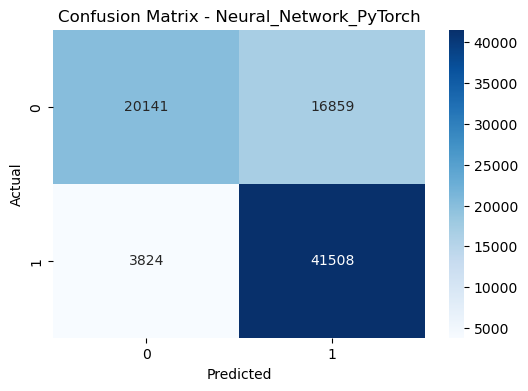

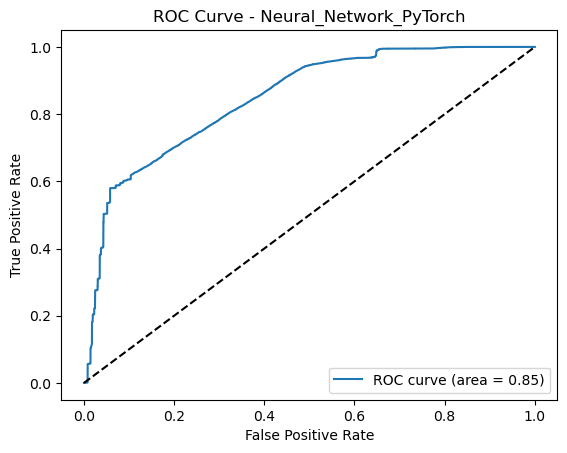

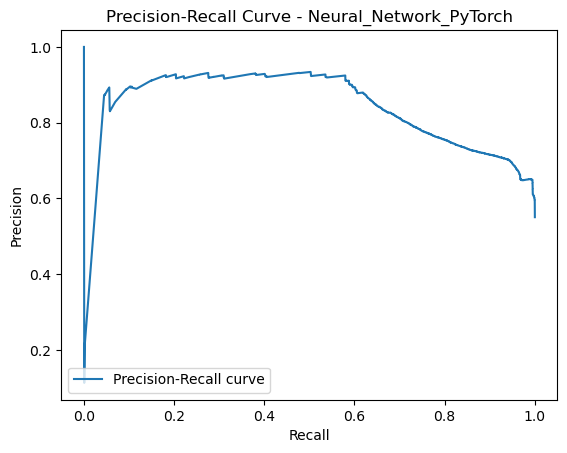

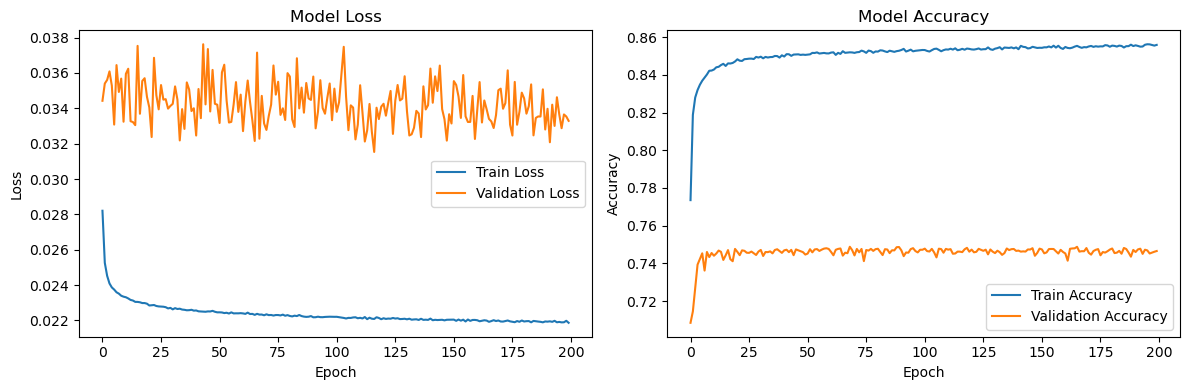

In [18]:
n_samples = len(y_train)
n_positive = sum(y_train)
ratio = (n_samples - n_positive) / n_positive
class_weight = {0: 1, 1: ratio}

model_name = "Neural_Network_PyTorch"
def focal_loss(alpha=0.25, gamma=2.0):
    def loss_fn(inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        p_t = torch.exp(-bce_loss)
        loss = alpha * (1 - p_t) ** gamma * bce_loss
        return loss.mean()
    return loss_fn
def prepare_dataloader(X, y, batch_size=32):
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

train_loader = prepare_dataloader(X_train, y_train)
val_loader = prepare_dataloader(X_test, y_test)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNNetwork(input_size=X_train.shape[1]).to(device)

loss_fn = focal_loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loss = []
val_loss_history = []
train_accuracy = []
val_accuracy = []

best_val_acc = 0.0
best_model_state = None

epochs = 200
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        predictions = (torch.sigmoid(outputs) > 0.5).float()
        correct += (predictions == y_batch).sum().item()
        total += y_batch.size(0)
    
    train_loss.append(total_loss / len(train_loader))
    train_acc = correct / total
    train_accuracy.append(train_acc)
    
    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_outputs = model(X_val)
            total_val_loss += loss_fn(val_outputs, y_val).item()
            
            predictions = (torch.sigmoid(val_outputs) > 0.5).float()
            correct += (predictions == y_val).sum().item()
            total += y_val.size(0)
    
    val_loss_history.append(total_val_loss / len(val_loader))
    val_acc = correct / total
    val_accuracy.append(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
    
    print(f"Epoch [{epoch+1}/{epochs}], Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Load the best model
model.load_state_dict(best_model_state)
model.eval()
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
with torch.no_grad():
    y_prob = torch.sigmoid(model(X_test_tensor).squeeze()).cpu().numpy()
    y_pred = (y_prob > 0.5).astype(int)

# Compute metrics
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Print metrics
print(f"=== {model_name} ===")
print(f"Accuracy: {acc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title(f"ROC Curve - {model_name}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
plt.figure()
plt.plot(recall_vals, precision_vals, label="Precision-Recall curve")
plt.title(f"Precision-Recall Curve - {model_name}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

### Logistic regression

In [19]:
# Logistic Regression Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)
    
    def forward(self, x):
        return self.linear(x)  # No activation, BCEWithLogitsLoss will handle sigmoid

Epoch [1/200], Train Acc: 0.7726, Val Acc: 0.7060


Epoch [2/200], Train Acc: 0.7919, Val Acc: 0.6506


Epoch [3/200], Train Acc: 0.7928, Val Acc: 0.7324


Epoch [4/200], Train Acc: 0.7955, Val Acc: 0.7385


Epoch [5/200], Train Acc: 0.7946, Val Acc: 0.6962


Epoch [6/200], Train Acc: 0.7983, Val Acc: 0.7080


Epoch [7/200], Train Acc: 0.7949, Val Acc: 0.7145


Epoch [8/200], Train Acc: 0.7966, Val Acc: 0.7111


Epoch [9/200], Train Acc: 0.7964, Val Acc: 0.7103


Epoch [10/200], Train Acc: 0.7963, Val Acc: 0.7117


Epoch [11/200], Train Acc: 0.7962, Val Acc: 0.7222


Epoch [12/200], Train Acc: 0.7970, Val Acc: 0.7478


Epoch [13/200], Train Acc: 0.7981, Val Acc: 0.7015


Epoch [14/200], Train Acc: 0.7980, Val Acc: 0.7079


Epoch [15/200], Train Acc: 0.7964, Val Acc: 0.6962


Epoch [16/200], Train Acc: 0.7963, Val Acc: 0.6962


Epoch [17/200], Train Acc: 0.7989, Val Acc: 0.7364


Epoch [18/200], Train Acc: 0.7983, Val Acc: 0.7028


Epoch [19/200], Train Acc: 0.7991, Val Acc: 0.7014


Epoch [20/200], Train Acc: 0.7981, Val Acc: 0.7178


Epoch [21/200], Train Acc: 0.7980, Val Acc: 0.7000


Epoch [22/200], Train Acc: 0.7983, Val Acc: 0.7496


Epoch [23/200], Train Acc: 0.7986, Val Acc: 0.6922


Epoch [24/200], Train Acc: 0.7977, Val Acc: 0.6919


Epoch [25/200], Train Acc: 0.7987, Val Acc: 0.7426


Epoch [26/200], Train Acc: 0.7975, Val Acc: 0.6887


Epoch [27/200], Train Acc: 0.7997, Val Acc: 0.7176


Epoch [28/200], Train Acc: 0.7985, Val Acc: 0.7113


Epoch [29/200], Train Acc: 0.7996, Val Acc: 0.7257


Epoch [30/200], Train Acc: 0.7985, Val Acc: 0.6953


Epoch [31/200], Train Acc: 0.8000, Val Acc: 0.7500


Epoch [32/200], Train Acc: 0.7986, Val Acc: 0.7331


Epoch [33/200], Train Acc: 0.8022, Val Acc: 0.6800


Epoch [34/200], Train Acc: 0.7991, Val Acc: 0.7109


Epoch [35/200], Train Acc: 0.8006, Val Acc: 0.6861


Epoch [36/200], Train Acc: 0.7988, Val Acc: 0.6982


Epoch [37/200], Train Acc: 0.8007, Val Acc: 0.7075


Epoch [38/200], Train Acc: 0.7997, Val Acc: 0.6987


Epoch [39/200], Train Acc: 0.7996, Val Acc: 0.7071


Epoch [40/200], Train Acc: 0.8006, Val Acc: 0.7141


Epoch [41/200], Train Acc: 0.8006, Val Acc: 0.6435


Epoch [42/200], Train Acc: 0.7997, Val Acc: 0.7159


Epoch [43/200], Train Acc: 0.8002, Val Acc: 0.6445


Epoch [44/200], Train Acc: 0.7996, Val Acc: 0.6946


Epoch [45/200], Train Acc: 0.8010, Val Acc: 0.7298


Epoch [46/200], Train Acc: 0.7995, Val Acc: 0.6946


Epoch [47/200], Train Acc: 0.8000, Val Acc: 0.6991


Epoch [48/200], Train Acc: 0.8007, Val Acc: 0.7139


Epoch [49/200], Train Acc: 0.7998, Val Acc: 0.7099


Epoch [50/200], Train Acc: 0.7990, Val Acc: 0.6694


Epoch [51/200], Train Acc: 0.8000, Val Acc: 0.6021


Epoch [52/200], Train Acc: 0.8004, Val Acc: 0.7422


Epoch [53/200], Train Acc: 0.8013, Val Acc: 0.7086


Epoch [54/200], Train Acc: 0.8009, Val Acc: 0.7116


Epoch [55/200], Train Acc: 0.8008, Val Acc: 0.7121


Epoch [56/200], Train Acc: 0.8005, Val Acc: 0.6945


Epoch [57/200], Train Acc: 0.8008, Val Acc: 0.7582


Epoch [58/200], Train Acc: 0.7994, Val Acc: 0.7377


Epoch [59/200], Train Acc: 0.8012, Val Acc: 0.7166


Epoch [60/200], Train Acc: 0.8001, Val Acc: 0.6847


Epoch [61/200], Train Acc: 0.8008, Val Acc: 0.7509


Epoch [62/200], Train Acc: 0.8016, Val Acc: 0.6936


Epoch [63/200], Train Acc: 0.8014, Val Acc: 0.7193


Epoch [64/200], Train Acc: 0.7999, Val Acc: 0.6981


Epoch [65/200], Train Acc: 0.8011, Val Acc: 0.7269


Epoch [66/200], Train Acc: 0.8016, Val Acc: 0.6883


Epoch [67/200], Train Acc: 0.8003, Val Acc: 0.7196


Epoch [68/200], Train Acc: 0.8009, Val Acc: 0.6910


Epoch [69/200], Train Acc: 0.7997, Val Acc: 0.6913


Epoch [70/200], Train Acc: 0.8034, Val Acc: 0.6991


Epoch [71/200], Train Acc: 0.8011, Val Acc: 0.6953


Epoch [72/200], Train Acc: 0.8015, Val Acc: 0.6976


Epoch [73/200], Train Acc: 0.8020, Val Acc: 0.6862


Epoch [74/200], Train Acc: 0.8020, Val Acc: 0.7200


Epoch [75/200], Train Acc: 0.8016, Val Acc: 0.7258


Epoch [76/200], Train Acc: 0.8022, Val Acc: 0.7172


Epoch [77/200], Train Acc: 0.8005, Val Acc: 0.7582


Epoch [78/200], Train Acc: 0.8014, Val Acc: 0.7435


Epoch [79/200], Train Acc: 0.8043, Val Acc: 0.7503


Epoch [80/200], Train Acc: 0.8004, Val Acc: 0.6912


Epoch [81/200], Train Acc: 0.8019, Val Acc: 0.7439


Epoch [82/200], Train Acc: 0.8000, Val Acc: 0.6969


Epoch [83/200], Train Acc: 0.8025, Val Acc: 0.6998


Epoch [84/200], Train Acc: 0.8003, Val Acc: 0.7001


Epoch [85/200], Train Acc: 0.8023, Val Acc: 0.6896


Epoch [86/200], Train Acc: 0.8010, Val Acc: 0.7213


Epoch [87/200], Train Acc: 0.8006, Val Acc: 0.6887


Epoch [88/200], Train Acc: 0.8019, Val Acc: 0.7456


Epoch [89/200], Train Acc: 0.8029, Val Acc: 0.6623


Epoch [90/200], Train Acc: 0.8017, Val Acc: 0.7416


Epoch [91/200], Train Acc: 0.8027, Val Acc: 0.7485


Epoch [92/200], Train Acc: 0.8008, Val Acc: 0.6501


Epoch [93/200], Train Acc: 0.8026, Val Acc: 0.7116


Epoch [94/200], Train Acc: 0.8013, Val Acc: 0.7031


Epoch [95/200], Train Acc: 0.8018, Val Acc: 0.7032


Epoch [96/200], Train Acc: 0.8018, Val Acc: 0.7213


Epoch [97/200], Train Acc: 0.8010, Val Acc: 0.7440


Epoch [98/200], Train Acc: 0.8035, Val Acc: 0.7187


Epoch [99/200], Train Acc: 0.8019, Val Acc: 0.7046


Epoch [100/200], Train Acc: 0.8027, Val Acc: 0.7504


Epoch [101/200], Train Acc: 0.8032, Val Acc: 0.6960


Epoch [102/200], Train Acc: 0.8015, Val Acc: 0.6861


Epoch [103/200], Train Acc: 0.8015, Val Acc: 0.6070


Epoch [104/200], Train Acc: 0.8016, Val Acc: 0.7468


Epoch [105/200], Train Acc: 0.8034, Val Acc: 0.6993


Epoch [106/200], Train Acc: 0.8026, Val Acc: 0.7503


Epoch [107/200], Train Acc: 0.8013, Val Acc: 0.7202


Epoch [108/200], Train Acc: 0.8019, Val Acc: 0.7044


Epoch [109/200], Train Acc: 0.8039, Val Acc: 0.7026


Epoch [110/200], Train Acc: 0.8017, Val Acc: 0.7505


Epoch [111/200], Train Acc: 0.8016, Val Acc: 0.7207


Epoch [112/200], Train Acc: 0.8015, Val Acc: 0.7389


Epoch [113/200], Train Acc: 0.8036, Val Acc: 0.6953


Epoch [114/200], Train Acc: 0.8029, Val Acc: 0.7502


Epoch [115/200], Train Acc: 0.8018, Val Acc: 0.6736


Epoch [116/200], Train Acc: 0.8019, Val Acc: 0.6845


Epoch [117/200], Train Acc: 0.8037, Val Acc: 0.6904


Epoch [118/200], Train Acc: 0.8032, Val Acc: 0.7504


Epoch [119/200], Train Acc: 0.8035, Val Acc: 0.7429


Epoch [120/200], Train Acc: 0.8030, Val Acc: 0.7182


Epoch [121/200], Train Acc: 0.8026, Val Acc: 0.6863


Epoch [122/200], Train Acc: 0.8025, Val Acc: 0.7173


Epoch [123/200], Train Acc: 0.8033, Val Acc: 0.7014


Epoch [124/200], Train Acc: 0.8024, Val Acc: 0.7357


Epoch [125/200], Train Acc: 0.8033, Val Acc: 0.7143


Epoch [126/200], Train Acc: 0.8022, Val Acc: 0.7447


Epoch [127/200], Train Acc: 0.8014, Val Acc: 0.6911


Epoch [128/200], Train Acc: 0.8016, Val Acc: 0.7203


Epoch [129/200], Train Acc: 0.8033, Val Acc: 0.7414


Epoch [130/200], Train Acc: 0.8046, Val Acc: 0.6922


Epoch [131/200], Train Acc: 0.8029, Val Acc: 0.7003


Epoch [132/200], Train Acc: 0.8026, Val Acc: 0.6901


Epoch [133/200], Train Acc: 0.8030, Val Acc: 0.6887


Epoch [134/200], Train Acc: 0.8031, Val Acc: 0.7176


Epoch [135/200], Train Acc: 0.8017, Val Acc: 0.7054


Epoch [136/200], Train Acc: 0.8034, Val Acc: 0.7504


Epoch [137/200], Train Acc: 0.8028, Val Acc: 0.7382


Epoch [138/200], Train Acc: 0.8034, Val Acc: 0.7078


Epoch [139/200], Train Acc: 0.8031, Val Acc: 0.7096


Epoch [140/200], Train Acc: 0.8019, Val Acc: 0.7502


Epoch [141/200], Train Acc: 0.8035, Val Acc: 0.6970


Epoch [142/200], Train Acc: 0.8034, Val Acc: 0.6944


Epoch [143/200], Train Acc: 0.8027, Val Acc: 0.7238


Epoch [144/200], Train Acc: 0.8037, Val Acc: 0.7063


Epoch [145/200], Train Acc: 0.8020, Val Acc: 0.7205


Epoch [146/200], Train Acc: 0.8047, Val Acc: 0.7135


Epoch [147/200], Train Acc: 0.8026, Val Acc: 0.7484


Epoch [148/200], Train Acc: 0.8032, Val Acc: 0.6964


Epoch [149/200], Train Acc: 0.8025, Val Acc: 0.7501


Epoch [150/200], Train Acc: 0.8036, Val Acc: 0.7033


Epoch [151/200], Train Acc: 0.8040, Val Acc: 0.7083


Epoch [152/200], Train Acc: 0.8025, Val Acc: 0.7503


Epoch [153/200], Train Acc: 0.8047, Val Acc: 0.7572


Epoch [154/200], Train Acc: 0.8044, Val Acc: 0.7432


Epoch [155/200], Train Acc: 0.8032, Val Acc: 0.6810


Epoch [156/200], Train Acc: 0.8047, Val Acc: 0.6915


Epoch [157/200], Train Acc: 0.8039, Val Acc: 0.7486


Epoch [158/200], Train Acc: 0.8040, Val Acc: 0.7463


Epoch [159/200], Train Acc: 0.8033, Val Acc: 0.6968


Epoch [160/200], Train Acc: 0.8016, Val Acc: 0.6953


Epoch [161/200], Train Acc: 0.8043, Val Acc: 0.7510


Epoch [162/200], Train Acc: 0.8043, Val Acc: 0.7582


Epoch [163/200], Train Acc: 0.8033, Val Acc: 0.7027


Epoch [164/200], Train Acc: 0.8036, Val Acc: 0.7357


Epoch [165/200], Train Acc: 0.8014, Val Acc: 0.6886


Epoch [166/200], Train Acc: 0.8031, Val Acc: 0.7449


Epoch [167/200], Train Acc: 0.8044, Val Acc: 0.7136


Epoch [168/200], Train Acc: 0.8030, Val Acc: 0.6873


Epoch [169/200], Train Acc: 0.8033, Val Acc: 0.7200


Epoch [170/200], Train Acc: 0.8039, Val Acc: 0.7519


Epoch [171/200], Train Acc: 0.8029, Val Acc: 0.7017


Epoch [172/200], Train Acc: 0.8051, Val Acc: 0.7502


Epoch [173/200], Train Acc: 0.8044, Val Acc: 0.7163


Epoch [174/200], Train Acc: 0.8039, Val Acc: 0.7134


Epoch [175/200], Train Acc: 0.8034, Val Acc: 0.7085


Epoch [176/200], Train Acc: 0.8035, Val Acc: 0.7578


Epoch [177/200], Train Acc: 0.8023, Val Acc: 0.7195


Epoch [178/200], Train Acc: 0.8030, Val Acc: 0.7090


Epoch [179/200], Train Acc: 0.8032, Val Acc: 0.7392


Epoch [180/200], Train Acc: 0.8040, Val Acc: 0.7367


Epoch [181/200], Train Acc: 0.8056, Val Acc: 0.7077


Epoch [182/200], Train Acc: 0.8030, Val Acc: 0.7101


Epoch [183/200], Train Acc: 0.8041, Val Acc: 0.7415


Epoch [184/200], Train Acc: 0.8032, Val Acc: 0.7093


Epoch [185/200], Train Acc: 0.8030, Val Acc: 0.7454


Epoch [186/200], Train Acc: 0.8035, Val Acc: 0.7503


Epoch [187/200], Train Acc: 0.8045, Val Acc: 0.7491


Epoch [188/200], Train Acc: 0.8031, Val Acc: 0.7489


Epoch [189/200], Train Acc: 0.8040, Val Acc: 0.7431


Epoch [190/200], Train Acc: 0.8034, Val Acc: 0.4251


Epoch [191/200], Train Acc: 0.8034, Val Acc: 0.7207


Epoch [192/200], Train Acc: 0.8035, Val Acc: 0.6906


Epoch [193/200], Train Acc: 0.8040, Val Acc: 0.7504


Epoch [194/200], Train Acc: 0.8032, Val Acc: 0.6933


Epoch [195/200], Train Acc: 0.8040, Val Acc: 0.6855


Epoch [196/200], Train Acc: 0.8057, Val Acc: 0.7045


Epoch [197/200], Train Acc: 0.8043, Val Acc: 0.7197


Epoch [198/200], Train Acc: 0.8056, Val Acc: 0.5752


Epoch [199/200], Train Acc: 0.8024, Val Acc: 0.7014


Epoch [200/200], Train Acc: 0.8039, Val Acc: 0.7190
=== Logistic Regression (PyTorch) ===
Accuracy: 0.7582
Recall: 0.6385
Precision: 0.8916
F1-Score: 0.7441
Sensitivity: 0.6385
Specificity: 0.9049

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.90      0.77     37000
           1       0.89      0.64      0.74     45332

    accuracy                           0.76     82332
   macro avg       0.78      0.77      0.76     82332
weighted avg       0.79      0.76      0.76     82332



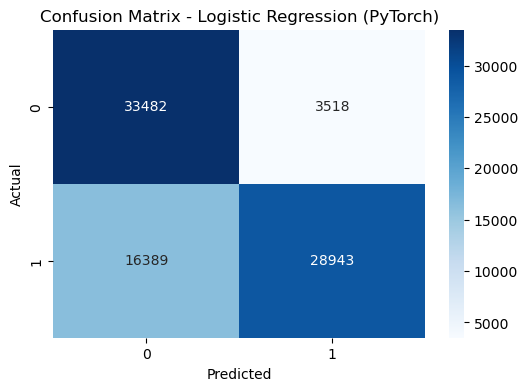

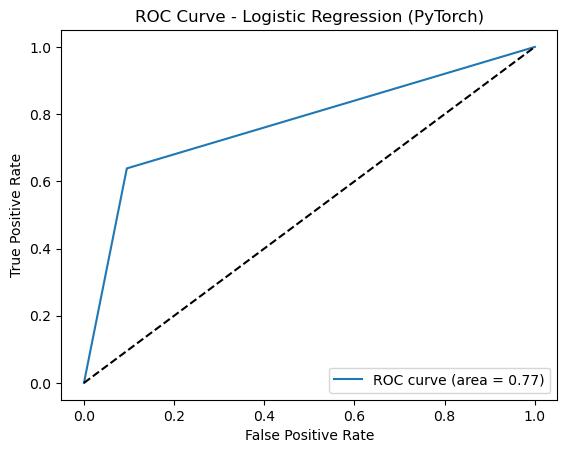

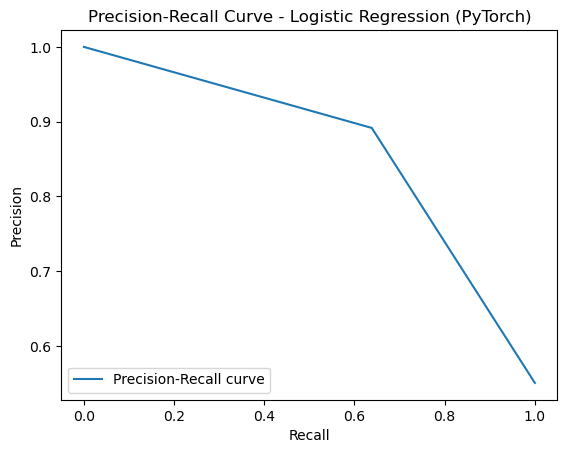

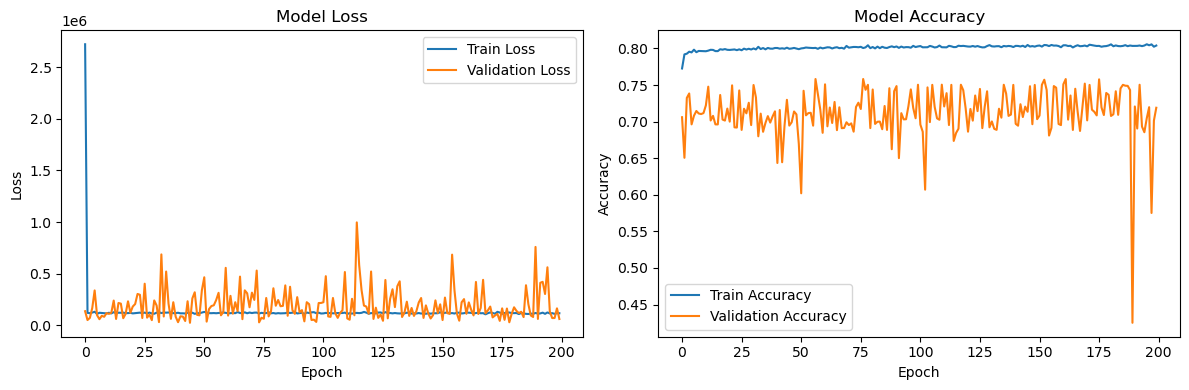

In [20]:
model_name = "Logistic Regression (PyTorch)"

# Prepare DataLoader
def prepare_dataloader(X, y, batch_size=32):
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Load dataset
train_loader = prepare_dataloader(X_train, y_train)
val_loader = prepare_dataloader(X_test, y_test)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LogisticRegression(input_size=X_train.shape[1]).to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_loss = []
val_loss_history = []
train_accuracy = []
val_accuracy = []

best_val_acc = 0.0
best_model_state = None

epochs = 200
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        predictions = (torch.sigmoid(outputs) > 0.5).float()
        correct += (predictions == y_batch).sum().item()
        total += y_batch.size(0)
    
    train_loss.append(total_loss / len(train_loader))
    train_acc = correct / total
    train_accuracy.append(train_acc)
    
    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_outputs = model(X_val)
            total_val_loss += loss_fn(val_outputs, y_val).item()
            
            predictions = (torch.sigmoid(val_outputs) > 0.5).float()
            correct += (predictions == y_val).sum().item()
            total += y_val.size(0)
    
    val_loss_history.append(total_val_loss / len(val_loader))
    val_acc = correct / total
    val_accuracy.append(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
    
    print(f"Epoch [{epoch+1}/{epochs}], Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Load the best model
model.load_state_dict(best_model_state)
model.eval()
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
with torch.no_grad():
    y_prob = torch.sigmoid(model(X_test_tensor).squeeze()).cpu().numpy()
    y_pred = (y_prob > 0.5).astype(int)

# Compute metrics
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Print metrics
print(f"=== {model_name} ===")
print(f"Accuracy: {acc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title(f"ROC Curve - {model_name}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
plt.figure()
plt.plot(recall_vals, precision_vals, label="Precision-Recall curve")
plt.title(f"Precision-Recall Curve - {model_name}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

Epoch [1/200], Train Acc: 0.6745, Val Acc: 0.7150


Epoch [2/200], Train Acc: 0.7871, Val Acc: 0.7031


Epoch [3/200], Train Acc: 0.7953, Val Acc: 0.6874


Epoch [4/200], Train Acc: 0.7947, Val Acc: 0.7473


Epoch [5/200], Train Acc: 0.7945, Val Acc: 0.6958


Epoch [6/200], Train Acc: 0.7956, Val Acc: 0.6127


Epoch [7/200], Train Acc: 0.7956, Val Acc: 0.7556


Epoch [8/200], Train Acc: 0.7962, Val Acc: 0.6877


Epoch [9/200], Train Acc: 0.7981, Val Acc: 0.3774


Epoch [10/200], Train Acc: 0.7962, Val Acc: 0.6910


Epoch [11/200], Train Acc: 0.7976, Val Acc: 0.7409


Epoch [12/200], Train Acc: 0.7964, Val Acc: 0.7491


Epoch [13/200], Train Acc: 0.7978, Val Acc: 0.7003


Epoch [14/200], Train Acc: 0.7976, Val Acc: 0.7489


Epoch [15/200], Train Acc: 0.7965, Val Acc: 0.7450


Epoch [16/200], Train Acc: 0.7978, Val Acc: 0.6901


Epoch [17/200], Train Acc: 0.7979, Val Acc: 0.7025


Epoch [18/200], Train Acc: 0.7970, Val Acc: 0.7090


Epoch [19/200], Train Acc: 0.8004, Val Acc: 0.7322


Epoch [20/200], Train Acc: 0.7982, Val Acc: 0.7220


Epoch [21/200], Train Acc: 0.7985, Val Acc: 0.4342


Epoch [22/200], Train Acc: 0.7966, Val Acc: 0.6928


Epoch [23/200], Train Acc: 0.7991, Val Acc: 0.6945


Epoch [24/200], Train Acc: 0.7997, Val Acc: 0.7457


Epoch [25/200], Train Acc: 0.7981, Val Acc: 0.6954


Epoch [26/200], Train Acc: 0.7992, Val Acc: 0.7192


Epoch [27/200], Train Acc: 0.7991, Val Acc: 0.7012


Epoch [28/200], Train Acc: 0.7986, Val Acc: 0.7540


Epoch [29/200], Train Acc: 0.7980, Val Acc: 0.6903


Epoch [30/200], Train Acc: 0.8006, Val Acc: 0.6936


Epoch [31/200], Train Acc: 0.7984, Val Acc: 0.7453


Epoch [32/200], Train Acc: 0.7987, Val Acc: 0.7471


Epoch [33/200], Train Acc: 0.7994, Val Acc: 0.7499


Epoch [34/200], Train Acc: 0.7984, Val Acc: 0.7114


Epoch [35/200], Train Acc: 0.7988, Val Acc: 0.7576


Epoch [36/200], Train Acc: 0.8002, Val Acc: 0.6009


Epoch [37/200], Train Acc: 0.7990, Val Acc: 0.7390


Epoch [38/200], Train Acc: 0.7996, Val Acc: 0.6983


Epoch [39/200], Train Acc: 0.7982, Val Acc: 0.6986


Epoch [40/200], Train Acc: 0.7989, Val Acc: 0.6823


Epoch [41/200], Train Acc: 0.8000, Val Acc: 0.7583


Epoch [42/200], Train Acc: 0.7999, Val Acc: 0.6974


Epoch [43/200], Train Acc: 0.7988, Val Acc: 0.6836


Epoch [44/200], Train Acc: 0.7983, Val Acc: 0.4437


Epoch [45/200], Train Acc: 0.8001, Val Acc: 0.7347


Epoch [46/200], Train Acc: 0.8016, Val Acc: 0.7254


Epoch [47/200], Train Acc: 0.8022, Val Acc: 0.6922


Epoch [48/200], Train Acc: 0.8012, Val Acc: 0.6944


Epoch [49/200], Train Acc: 0.7995, Val Acc: 0.6883


Epoch [50/200], Train Acc: 0.8001, Val Acc: 0.7060


Epoch [51/200], Train Acc: 0.8004, Val Acc: 0.6826


Epoch [52/200], Train Acc: 0.8012, Val Acc: 0.7468


Epoch [53/200], Train Acc: 0.8015, Val Acc: 0.6078


Epoch [54/200], Train Acc: 0.8011, Val Acc: 0.7106


Epoch [55/200], Train Acc: 0.7999, Val Acc: 0.7043


Epoch [56/200], Train Acc: 0.8025, Val Acc: 0.7175


Epoch [57/200], Train Acc: 0.8016, Val Acc: 0.7345


Epoch [58/200], Train Acc: 0.8002, Val Acc: 0.6891


Epoch [59/200], Train Acc: 0.8028, Val Acc: 0.7253


Epoch [60/200], Train Acc: 0.7998, Val Acc: 0.7431


Epoch [61/200], Train Acc: 0.8014, Val Acc: 0.6963


Epoch [62/200], Train Acc: 0.8014, Val Acc: 0.7575


Epoch [63/200], Train Acc: 0.8014, Val Acc: 0.6993


Epoch [64/200], Train Acc: 0.7999, Val Acc: 0.7444


Epoch [65/200], Train Acc: 0.8024, Val Acc: 0.7354


Epoch [66/200], Train Acc: 0.8005, Val Acc: 0.7048


Epoch [67/200], Train Acc: 0.8035, Val Acc: 0.7007


Epoch [68/200], Train Acc: 0.7999, Val Acc: 0.6020


Epoch [69/200], Train Acc: 0.8023, Val Acc: 0.7247


Epoch [70/200], Train Acc: 0.8039, Val Acc: 0.7351


Epoch [71/200], Train Acc: 0.8011, Val Acc: 0.6657


Epoch [72/200], Train Acc: 0.8006, Val Acc: 0.6991


Epoch [73/200], Train Acc: 0.8013, Val Acc: 0.7048


Epoch [74/200], Train Acc: 0.8001, Val Acc: 0.6935


Epoch [75/200], Train Acc: 0.8015, Val Acc: 0.4415


Epoch [76/200], Train Acc: 0.8020, Val Acc: 0.7047


Epoch [77/200], Train Acc: 0.8015, Val Acc: 0.7355


Epoch [78/200], Train Acc: 0.8033, Val Acc: 0.7502


Epoch [79/200], Train Acc: 0.8028, Val Acc: 0.7353


Epoch [80/200], Train Acc: 0.8006, Val Acc: 0.6423


Epoch [81/200], Train Acc: 0.8012, Val Acc: 0.7219


Epoch [82/200], Train Acc: 0.8018, Val Acc: 0.7501


Epoch [83/200], Train Acc: 0.8022, Val Acc: 0.7534


Epoch [84/200], Train Acc: 0.8030, Val Acc: 0.7111


Epoch [85/200], Train Acc: 0.8027, Val Acc: 0.6987


Epoch [86/200], Train Acc: 0.8022, Val Acc: 0.7562


Epoch [87/200], Train Acc: 0.8026, Val Acc: 0.6902


Epoch [88/200], Train Acc: 0.8024, Val Acc: 0.7051


Epoch [89/200], Train Acc: 0.8017, Val Acc: 0.6400


Epoch [90/200], Train Acc: 0.8020, Val Acc: 0.7174


Epoch [91/200], Train Acc: 0.8020, Val Acc: 0.6990


Epoch [92/200], Train Acc: 0.8017, Val Acc: 0.7502


Epoch [93/200], Train Acc: 0.8040, Val Acc: 0.6908


Epoch [94/200], Train Acc: 0.8019, Val Acc: 0.6950


Epoch [95/200], Train Acc: 0.8013, Val Acc: 0.6958


Epoch [96/200], Train Acc: 0.8025, Val Acc: 0.6948


Epoch [97/200], Train Acc: 0.8033, Val Acc: 0.7007


Epoch [98/200], Train Acc: 0.8022, Val Acc: 0.6873


Epoch [99/200], Train Acc: 0.8015, Val Acc: 0.5081


Epoch [100/200], Train Acc: 0.8032, Val Acc: 0.6959


Epoch [101/200], Train Acc: 0.8046, Val Acc: 0.7354


Epoch [102/200], Train Acc: 0.8023, Val Acc: 0.6771


Epoch [103/200], Train Acc: 0.8026, Val Acc: 0.7352


Epoch [104/200], Train Acc: 0.8026, Val Acc: 0.7197


Epoch [105/200], Train Acc: 0.8024, Val Acc: 0.7543


Epoch [106/200], Train Acc: 0.8014, Val Acc: 0.7036


Epoch [107/200], Train Acc: 0.8027, Val Acc: 0.7389


Epoch [108/200], Train Acc: 0.8034, Val Acc: 0.7052


Epoch [109/200], Train Acc: 0.8021, Val Acc: 0.7132


Epoch [110/200], Train Acc: 0.8014, Val Acc: 0.7038


Epoch [111/200], Train Acc: 0.8041, Val Acc: 0.7502


Epoch [112/200], Train Acc: 0.8027, Val Acc: 0.7110


Epoch [113/200], Train Acc: 0.8031, Val Acc: 0.7527


Epoch [114/200], Train Acc: 0.8031, Val Acc: 0.6953


Epoch [115/200], Train Acc: 0.8026, Val Acc: 0.6830


Epoch [116/200], Train Acc: 0.8019, Val Acc: 0.6924


Epoch [117/200], Train Acc: 0.8022, Val Acc: 0.6919


Epoch [118/200], Train Acc: 0.8025, Val Acc: 0.6896


Epoch [119/200], Train Acc: 0.8032, Val Acc: 0.7441


Epoch [120/200], Train Acc: 0.8033, Val Acc: 0.7047


Epoch [121/200], Train Acc: 0.8033, Val Acc: 0.7499


Epoch [122/200], Train Acc: 0.8037, Val Acc: 0.7377


Epoch [123/200], Train Acc: 0.8041, Val Acc: 0.6941


Epoch [124/200], Train Acc: 0.8028, Val Acc: 0.7020


Epoch [125/200], Train Acc: 0.8023, Val Acc: 0.7500


Epoch [126/200], Train Acc: 0.8030, Val Acc: 0.7054


Epoch [127/200], Train Acc: 0.8032, Val Acc: 0.6995


Epoch [128/200], Train Acc: 0.8011, Val Acc: 0.7023


Epoch [129/200], Train Acc: 0.8032, Val Acc: 0.7491


Epoch [130/200], Train Acc: 0.8013, Val Acc: 0.7146


Epoch [131/200], Train Acc: 0.8042, Val Acc: 0.7047


Epoch [132/200], Train Acc: 0.8017, Val Acc: 0.7010


Epoch [133/200], Train Acc: 0.8026, Val Acc: 0.6992


Epoch [134/200], Train Acc: 0.8032, Val Acc: 0.7494


Epoch [135/200], Train Acc: 0.8039, Val Acc: 0.7134


Epoch [136/200], Train Acc: 0.8028, Val Acc: 0.7131


Epoch [137/200], Train Acc: 0.8013, Val Acc: 0.6959


Epoch [138/200], Train Acc: 0.8032, Val Acc: 0.7491


Epoch [139/200], Train Acc: 0.8018, Val Acc: 0.7360


Epoch [140/200], Train Acc: 0.8043, Val Acc: 0.7470


Epoch [141/200], Train Acc: 0.8029, Val Acc: 0.6132


Epoch [142/200], Train Acc: 0.8016, Val Acc: 0.6995


Epoch [143/200], Train Acc: 0.8036, Val Acc: 0.7500


Epoch [144/200], Train Acc: 0.8036, Val Acc: 0.6934


Epoch [145/200], Train Acc: 0.8026, Val Acc: 0.7429


Epoch [146/200], Train Acc: 0.8032, Val Acc: 0.7108


Epoch [147/200], Train Acc: 0.8015, Val Acc: 0.7503


Epoch [148/200], Train Acc: 0.8039, Val Acc: 0.6955


Epoch [149/200], Train Acc: 0.8037, Val Acc: 0.7125


Epoch [150/200], Train Acc: 0.8039, Val Acc: 0.4292


Epoch [151/200], Train Acc: 0.8031, Val Acc: 0.7377


Epoch [152/200], Train Acc: 0.8028, Val Acc: 0.7503


Epoch [153/200], Train Acc: 0.8045, Val Acc: 0.6785


Epoch [154/200], Train Acc: 0.8025, Val Acc: 0.6915


Epoch [155/200], Train Acc: 0.8033, Val Acc: 0.7106


Epoch [156/200], Train Acc: 0.8032, Val Acc: 0.6977


Epoch [157/200], Train Acc: 0.8026, Val Acc: 0.7451


Epoch [158/200], Train Acc: 0.8033, Val Acc: 0.6955


Epoch [159/200], Train Acc: 0.8039, Val Acc: 0.7109


Epoch [160/200], Train Acc: 0.8033, Val Acc: 0.6974


Epoch [161/200], Train Acc: 0.8037, Val Acc: 0.7037


Epoch [162/200], Train Acc: 0.8062, Val Acc: 0.6955


Epoch [163/200], Train Acc: 0.8022, Val Acc: 0.6987


Epoch [164/200], Train Acc: 0.8039, Val Acc: 0.7427


Epoch [165/200], Train Acc: 0.8027, Val Acc: 0.6985


Epoch [166/200], Train Acc: 0.8029, Val Acc: 0.7240


Epoch [167/200], Train Acc: 0.8038, Val Acc: 0.6878


Epoch [168/200], Train Acc: 0.8034, Val Acc: 0.7186


Epoch [169/200], Train Acc: 0.8037, Val Acc: 0.7085


Epoch [170/200], Train Acc: 0.8027, Val Acc: 0.7482


Epoch [171/200], Train Acc: 0.8046, Val Acc: 0.7184


Epoch [172/200], Train Acc: 0.8031, Val Acc: 0.7203


Epoch [173/200], Train Acc: 0.8039, Val Acc: 0.7107


Epoch [174/200], Train Acc: 0.8044, Val Acc: 0.7214


Epoch [175/200], Train Acc: 0.8042, Val Acc: 0.7363


Epoch [176/200], Train Acc: 0.8046, Val Acc: 0.7198


Epoch [177/200], Train Acc: 0.8050, Val Acc: 0.6949


Epoch [178/200], Train Acc: 0.8048, Val Acc: 0.7587


Epoch [179/200], Train Acc: 0.8021, Val Acc: 0.7211


Epoch [180/200], Train Acc: 0.8053, Val Acc: 0.6852


Epoch [181/200], Train Acc: 0.8047, Val Acc: 0.7049


Epoch [182/200], Train Acc: 0.8030, Val Acc: 0.6228


Epoch [183/200], Train Acc: 0.8045, Val Acc: 0.7426


Epoch [184/200], Train Acc: 0.8045, Val Acc: 0.6010


Epoch [185/200], Train Acc: 0.8033, Val Acc: 0.7501


Epoch [186/200], Train Acc: 0.8035, Val Acc: 0.6974


Epoch [187/200], Train Acc: 0.8038, Val Acc: 0.7499


Epoch [188/200], Train Acc: 0.8043, Val Acc: 0.7038


Epoch [189/200], Train Acc: 0.8019, Val Acc: 0.7501


Epoch [190/200], Train Acc: 0.8035, Val Acc: 0.7085


Epoch [191/200], Train Acc: 0.8037, Val Acc: 0.6874


Epoch [192/200], Train Acc: 0.8030, Val Acc: 0.7363


Epoch [193/200], Train Acc: 0.8041, Val Acc: 0.7208


Epoch [194/200], Train Acc: 0.8032, Val Acc: 0.6708


Epoch [195/200], Train Acc: 0.8033, Val Acc: 0.6942


Epoch [196/200], Train Acc: 0.8017, Val Acc: 0.7576


Epoch [197/200], Train Acc: 0.8043, Val Acc: 0.6895


Epoch [198/200], Train Acc: 0.8036, Val Acc: 0.6970


Epoch [199/200], Train Acc: 0.8028, Val Acc: 0.7047


Epoch [200/200], Train Acc: 0.8034, Val Acc: 0.7502
=== Logistic Regression (PyTorch) lr-4 ===
Accuracy: 0.7587
Recall: 0.6464
Precision: 0.8842
F1-Score: 0.7468
Sensitivity: 0.6464
Specificity: 0.8963

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.90      0.77     37000
           1       0.88      0.65      0.75     45332

    accuracy                           0.76     82332
   macro avg       0.78      0.77      0.76     82332
weighted avg       0.79      0.76      0.76     82332



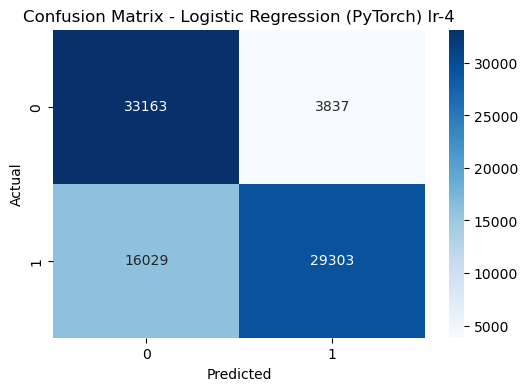

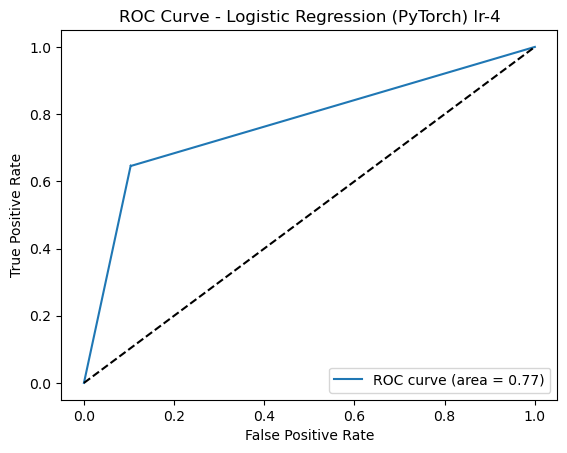

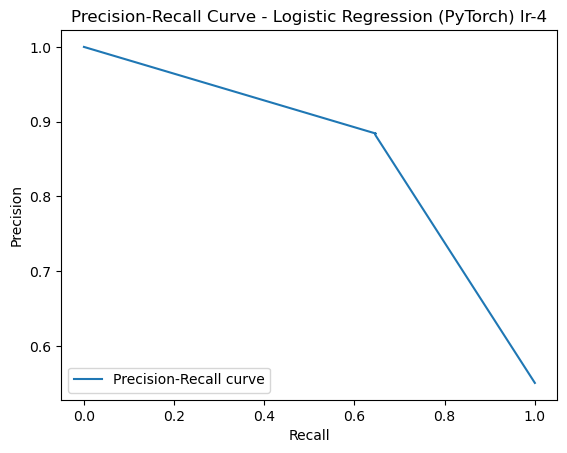

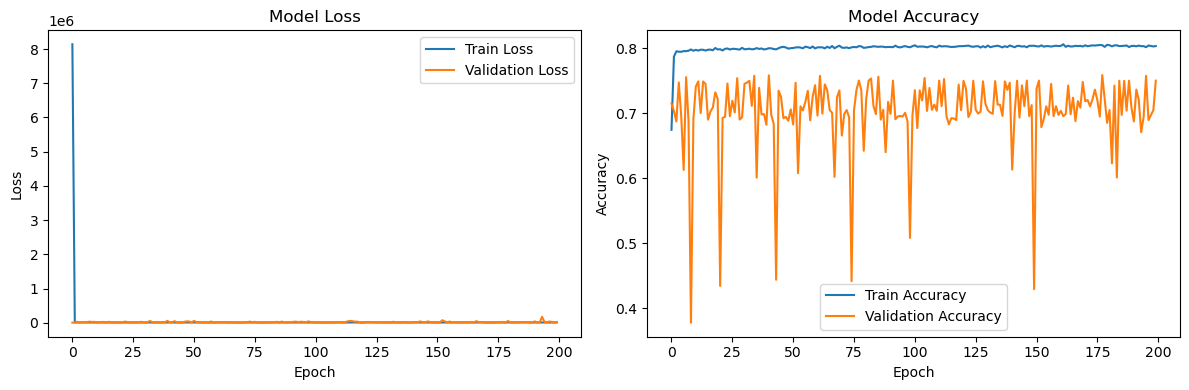

In [21]:
model_name = "Logistic Regression (PyTorch) lr-4"

# Prepare DataLoader
def prepare_dataloader(X, y, batch_size=32):
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32).unsqueeze(1)
    dataset = TensorDataset(X_tensor, y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Load dataset
train_loader = prepare_dataloader(X_train, y_train)
val_loader = prepare_dataloader(X_test, y_test)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LogisticRegression(input_size=X_train.shape[1]).to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_loss = []
val_loss_history = []
train_accuracy = []
val_accuracy = []

best_val_acc = 0.0
best_model_state = None

epochs = 200
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        predictions = (torch.sigmoid(outputs) > 0.5).float()
        correct += (predictions == y_batch).sum().item()
        total += y_batch.size(0)
    
    train_loss.append(total_loss / len(train_loader))
    train_acc = correct / total
    train_accuracy.append(train_acc)
    
    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            val_outputs = model(X_val)
            total_val_loss += loss_fn(val_outputs, y_val).item()
            
            predictions = (torch.sigmoid(val_outputs) > 0.5).float()
            correct += (predictions == y_val).sum().item()
            total += y_val.size(0)
    
    val_loss_history.append(total_val_loss / len(val_loader))
    val_acc = correct / total
    val_accuracy.append(val_acc)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = copy.deepcopy(model.state_dict())
    
    print(f"Epoch [{epoch+1}/{epochs}], Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Load the best model
model.load_state_dict(best_model_state)
model.eval()
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
with torch.no_grad():
    y_prob = torch.sigmoid(model(X_test_tensor).squeeze()).cpu().numpy()
    y_pred = (y_prob > 0.5).astype(int)

# Compute metrics
acc = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

# Print metrics
print(f"=== {model_name} ===")
print(f"Accuracy: {acc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title(f"ROC Curve - {model_name}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
plt.figure()
plt.plot(recall_vals, precision_vals, label="Precision-Recall curve")
plt.title(f"Precision-Recall Curve - {model_name}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()